# FINM 33150 | Final Project Draft

Stephen Coley, Harrison Holt, Josh Li, Kyle Parran

March 13, 2025

## The Task

The end goal here is to invent, simulate, and analyze a quantitative trading strategy.

Our initial ideas for a strategy include:


Once we determine a viable strategy we will need to ensure such a strategy has the following features:
- Investment in publicly traded (but not necessarily electronically traded) assets
- A "recipe" for evaluating attractiveness of potential trades that
    - depend on pre-specified classes of info
    - could be followed by anyone, given the recipe and data sources
- A "recipe" for investment sizes, and position entry and exit rules, that
    - may link position size to attractiveness
    - ensures risk stays within limits and capital remains bounded
    - makes reasonable assumptions about entry and exit liquidity

Elements of trading strategies include lead-lag relationships, market making, carry trades, pair trading, factor investment, model reversion, merger arbitrage, technical signals, etc.

Our strategy should have the following features:
- Significant dependence on at least one class of information that is not twitter, equity ohlc, equity VWAPs, or equity trading volumes, unelss at a relatively high frequency (600 secs or less)
- As of at least some times in your simulation, simultaneously holds at least 5 distinct assets (different currencies, commodities, option maturities/strikes etc.)
- Produces a total of 40 trades or more over your entire analysis/simulation period, without excessive clustering
- Leverage, with documented and reasonable capital and risk control assumptions


## Outline

### 1. Introduction

### 2. Data Assembly

### 3. Data Analysis

--------Next Phase--------

### 4. Strategy Implementation

### 6. Backtesting

### 7. Performance Analysis

### 8. References

## Introduction

### **Strategy Overview**
The objective of this strategy is to develop a quantile-based trading model that ranks equities based on their expected price drift following an earnings surprise announcement. The expected drift is estimated by comparing the earnings surprise percentage for each quarter with the next-day price movement of that equity. The assumption is that the smaller the price reaction relative to the earnings surprise, the more post-earnings drift there is to capture. 

To standardize this metric, we will z-score the "surprise vs. price move" metric within bins based on average EPS size to control for the effects of large versus small earnings surprises. To enhance diversification, additional fundamental and technical indicators related to growth and momentum will also be incorporated, each standardized through z-scoring within their respective bins. 

Initially, the "surprise vs. price move" metric will be weighted more heavilym as it forms the core of our thesis, with the flexibility to adjust the weights of other indicators based on observed results. Further details on data collection, execution methodology, and risk/liquidity constraints are outlined below.

### **Objective Based on Research**
Develop a quantile-based long-short strategy that exploits:
- The Disposition Effect (investors' tendency to hold losses and sell gains)
- Underreaction to News (price drift following earnings/news events)
- Momentum Effects (continuation of trends in stock returns)
- Post-earnings Announcement Drift (PEAD) (slow reaction to earnings surprises)

### **Data Acquisition**
- **EPS Actual Data and Consensus Estimates/Surprise Metrics** from WRDS I/B/E/S
- **Equity Close Prices** from NASDAQ's 'QUOTEMEDIA/PRICES' dataset
- **Fundamental and Market Value Data** from NASDAQ's ZACKS Fundamental B dataset

### **Stock Universe:**
- US listed equities
- Market Cap > $500M (focus on mid-to-large cap stocks)
- Excludes ADRs, ETFs, & illiquid stocks

### **Additional Constraints/Specifications**
- **Long/Short Quantile Approach:** To minimize risk, we implement a market-neutral long/short quantile approach.
- **Stop-Loss Protection:** Each stock position will have a 5% stop-loss limit to mitigate downside risk.
- **Position Sizing:**
  - No single stock will exceed 5% of total portfolio value.
  - We will allocate larger position sizes to the higher-ranked quantile equities within our strategy's framework.
  - Potential for Dynamic Positioning: Stocks with stronger composite rankings receive larger allocations.
- **Liquidity Constraints:** The investable universe is limited to stocks with market capitalization > $500M, ensuring sufficient liquidity.
- **Leverage & Capital Structure:**
  - We will set initial capital as 10x gross notional of the first month’s set of positions.
  - Net value of long and short positions will determine the capital allocation at each rebalance.
  - Securities will be easy to borrow, with a repo rate equal to the funding rate minus 100bps:
    
    $$repo\ rate = funding\ rate - 0.01$$
    
  - A constant funding rate of 4.30% (approximate 3-month SOFR rate) is assumed for ease of calculations.
  - The total invested capital is calculated as:
    
   $$\sum(adjusted\ prices_i*positions_i) * 10 $$

- **Capital Adjustment:** At each rebalance/lookback period, we will adjust capital based on both realized and unrealized PnL while maintaining the 10x leverage structure throughout the lifecycle of the strategy.

### **Constraints/Parameters to Test and Optimize**

**1. Quantile Size (q)**
- The number of quantiles (e.g., 5, 10) will be tested to optimize trade selection.
- Within each quantile, equities can be equally or dynamically weighted; instead, we will assign higher weights to better-ranked equities and lower weights to weaker-ranked equities.

**2. Lookback Period (L)**
- We will evaluate different lookback periods, comparing a static 3-month rebalancing strategy with a more dynamic shorter-period rebalancing approach:
  - **3-Month Approach:** Portfolio holdings will be adjusted every quarter based on the latest earnings surprise and fundamental rankings.
  - **Shorter Lookback Periods:**
    - A rolling ranking system will be used, where equities are added as earnings are announced.
    - Re-evaluations will take place after each L-period, ensuring rankings and portfolio holdings remain responsive to new earnings data.
- Why Optimize Lookback Period
    - A longer rebalancing period allows broader trend capture but may introduce factor decay.
    - A shorter rebalancing period allows faster trade turnover, enhancing alpha generation.

**3. Core Features Used for Ranking**
- Earnings Surprise Score (SUE) – Difference between actual and expected earnings.
- Price Drift Factor – Captures post-earnings price movement inefficiencies.
- Momentum Metrics – Trend indicators
- Volatility Adjustments – Stock-specific risk factors to control for extreme price swings.
- Fundamental Factors – Growth and valuation measures (e.g., P/E ratio, revenue growth, leverage metrics).
- All features are z-scored within bins to normalize comparisons across market caps and industries.

### **Strategy Risks & Mitigation Measures**

**1. Idiosyncratic Risks (Stock-specific risks)**
- Unexpected Corporate Actions: Mergers, acquisitions, or earnings restatements can distort expected drift.
- High Short Interest Stocks: Can be vulnerable to short squeezes (e.g., meme stocks).

- Mitigation
    - Sector/Stock Diversification: Spreading risk across multiple earnings events.
    - Beta-Neutral Construction: Balancing longs and shorts to limit market-wide exposure.

**2. Model Risks & Overfitting**
- Factor Decay: If too many funds use this strategy edge may decline
- Overfitting Risk: Risk of over optimizing to much to historical data, reduces robustness

- Mitigation
    - Regular factor re-ranking & feature selection: ensures model remains adaptive
    - Stress testing in different regimes: evaluates robustness in different conditions

## Setup

In [226]:
import pandas as pd
import numpy as np
import nasdaqdatalink as ndl
import quandl
import wrds
from dotenv import load_dotenv
import os
import datetime
from datetime import timedelta
from plotnine import ggplot, aes, geom_line, scale_color_manual, geom_hline, labs, theme, element_text, facet_wrap, geom_histogram, ggtitle, geom_boxplot, stat_function, geom_density
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings
from mpl_toolkits.mplot3d import Axes3D
import functools
from scipy.stats import zscore
from sklearn.decomposition import PCA
from functools import lru_cache
import pytz
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.ticker as mticker
def thousands_formatter(x, pos):
    return f'{int(x/1000)}K'  # Convert to thousands and append 'K'


proj_dir = Path.cwd().parent
base_dir = proj_dir.parent
import sys
sys.path.append(str(proj_dir))

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

start_filter_date = '2018-01-01'
end_filter_date = '2024-12-31'

data_start_date = '2019-01-01'
data_end_date = '2024-12-31'

start_filing_date = '2014-01-01'
end_filing_date = '2024-12-31'

year_beginning_filing = pd.to_datetime(start_filing_date).year
year_end_filing = pd.to_datetime(end_filing_date).year
year_beginning_filter = pd.to_datetime(start_filter_date).year
year_end_filter = pd.to_datetime(end_filter_date).year

load_dotenv()

ndl.ApiConfig.api_key = os.getenv('NDL_API_KEY')
quandl_api_key = os.getenv('NDL_API_KEY')
wrds_username = os.getenv('WRDS_USERNAME')
adv_api_key = os.getenv('ADV_API_KEY')

db = wrds.Connection(wrds_username=wrds_username, verbose = False)

Loading library list...
Done


## Functions

In [6]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.path.expanduser("~"), "quandl_data_table_downloads")
    if not os.path.exists(root_data_dir):
        print(f"Directory does not exist. Creating: {root_data_dir}")
        os.makedirs(root_data_dir, exist_ok=True)
    else:
        print(f"Directory already exists: {root_data_dir}")

    data_symlink = os.path.normpath(os.path.join(root_data_dir, f"{table_path}_latest.zip"))

    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)

    print(table_dir)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.normpath(os.path.join(root_data_dir, f"{table_path}_{my_date}.zip"))

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, 
        filename=data_file, 
        api_key=os.getenv('NDL_API_KEY'), 
        **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        print(data_symlink)
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

## Data Assembly

### Data load

**Zacks Fundamental B**

| Table                       | Table Code   | Table Description                                                                                                                                                                                                                                                                   |
|-----------------------------|--------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Fundamentals Condensed      | ZACKS/FC     | This table contains over 200 fundamental indicators for over 19,500 companies including over 10,000 delisted stocks. For access to additional indicators see Zacks Fundamentals C.                                                                                                    |
| Fundamentals Ratios         | ZACKS/FR     | This table contains 26 fundamental ratios for over 19,500 companies, including over 10,000 delisted stocks.                                                                                                                                                                           |
| Master Table                | ZACKS/MT     | This table contains descriptive information about all tickers that are included in Zacks products.                                                                                                                                                                                   |
| Market Value Supplement     | ZACKS/MKTV   | This table contains supplementary information to Zacks fundamentals, with updated values for market capitalization and enterprise value. Market cap is the total value of all of a company's outstanding stock. You calculate it by multiplying the current stock price by the number of shares owned by stockholders. |
| Shares Out Supplement       | ZACKS/SHRS   | This table contains supplementary information to Zacks fundamentals, with updated values for common shares outstanding and average diluted shares outstanding. Shares outstanding are the total number of shares issued by a corporation.                                              |
| Historical Daily Maintenance| ZACKS/HDM    | This table offers historical daily corporate actions for over 7,000 U.S. and Canadian listed companies. Sometimes the price of a stock changes because of events that are not associated with the supply-and-demand forces of the markets. For instance, if a company declares a stock split or reverse stock split, the share price will change radically, even though it does not actually affect the value of the company or investors' holdings in the stock. The adjusted close price shows the effect of these events. |

In [7]:

zacks_fc = fetch_quandl_table('ZACKS/FC', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_fr = fetch_quandl_table('ZACKS/FR', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_mt = fetch_quandl_table('ZACKS/MT', avoid_download=True)
zacks_mktv = fetch_quandl_table('ZACKS/MKTV', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_shrs = fetch_quandl_table('ZACKS/SHRS', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_hdm = fetch_quandl_table('ZACKS/HDM', avoid_download=True)

zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['filing_date'] = pd.to_datetime(zacks_fc['filing_date'])+timedelta(days=1)
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_mktv['per_end_date'] = pd.to_datetime(zacks_mktv['per_end_date'])
zacks_shrs['per_end_date'] = pd.to_datetime(zacks_shrs['per_end_date'])
zacks_fc = zacks_fc.dropna(subset=['per_end_date', 'filing_date'])

zacks_data = pd.merge(zacks_fc, zacks_fr, on=['ticker', 'per_end_date', 'per_type'], how='left', suffixes=('_fc', '_fr'))
zacks_data = pd.merge(zacks_data, zacks_mktv, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_data = pd.merge(zacks_data, zacks_shrs, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_data = pd.merge(zacks_data, zacks_mt, on=['ticker'], how='left')

Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/FC
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/FR
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/MT
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/MKTV
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/SHRS
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/HDM


In [ ]:
# zacks_data.to_pickle('zacks_data.pkl')
# zacks_data = pd.read_pickle('zacks_data.pkl')

In [9]:
top_stocks = zacks_mktv.loc[(zacks_mktv['per_end_date'] == zacks_mktv.per_end_date.max()) & (zacks_mktv['mkt_val']>=500)].sort_values(by='mkt_val', ascending=False).copy().reset_index(drop=True)
top_tickers = tuple(top_stocks.ticker)
top_tickers_list = list(top_tickers)

print(f"{len(top_tickers):,} tickers with market cap >= 500M")

3,196 tickers with market cap >= 500M


**Quandl EOD price data**

When referencing price end of day price data we will utilize Quandl End of Day US Stock Prices. Updated daily, this data feed offers end of day prices, dividends, adjustments and splits for U.S. publicly traded stocks with history to 1996. Prices are provided both adjusted and unadjusted.

Key Features:

- Covers all stocks with primary listing on NASDAQ, AMEX, NYSE and ARCA.
- Includes unadjusted and adjusted open, high, low, close, volume.
- Includes dividend history and split history.
- Updated at or before 5:00 pm ET on all trading days.
- Exchange corrections are applied by 9:30 pm ET.
- Historical data goes back to 1996.

In [ ]:
eod_data = fetch_quandl_table(
    'QUOTEMEDIA/PRICES', 
    avoid_download=True,
    ticker=top_tickers_list
)

spy_eod_data =  eod_data.loc[
                            (eod_data.ticker.isin(['SPY']))
                            & (eod_data.date >= start_filter_date)
                            & (eod_data.date <= end_filter_date)
                        ].copy()

spy_eod_data = spy_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

top_eod_data = eod_data.loc[
                            (eod_data.ticker.isin(top_tickers_list))
                            & (eod_data.date >= start_filter_date)
                            & (eod_data.date <= end_filter_date)
                        ].copy()

top_eod_data = top_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)



import gc
del eod_data
gc.collect()

# spy_eod_data.to_parquet(f'../data/spy_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')
# top_eod_data.to_parquet(f'../data/top_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')

# spy_eod_data = pd.read_parquet(f'../data/spy_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')
# top_eod_data = pd.read_parquet(f'../data/top_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')

spy_eod_data['daily_rets'] = spy_eod_data.groupby('ticker')['adj_close'].pct_change()
top_eod_data['daily_rets'] = top_eod_data.groupby('ticker')['adj_close'].pct_change()

display(top_eod_data.head())
display(top_eod_data.tail())
display(top_eod_data.describe())
display(top_eod_data.info())

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_rets
0,A,2018-01-02,67.42,67.89,67.340,67.60,1047830.0,0.0,1.0,64.141233,64.588376,64.065123,64.312479,1047830.0,NaN
1,A,2018-01-03,67.62,69.49,67.600,69.32,1698899.0,0.0,1.0,64.331506,66.110565,64.312479,65.948832,1698899.0,0.025444
2,A,2018-01-04,69.54,69.82,68.780,68.80,2231534.0,0.0,1.0,66.158133,66.424516,65.435093,65.454121,2231534.0,-0.007501
3,A,2018-01-05,68.73,70.10,68.730,69.90,1632512.0,0.0,1.0,65.387525,66.690899,65.387525,66.500625,1632512.0,0.015988
4,A,2018-01-08,69.73,70.33,69.545,70.05,1613911.0,0.0,1.0,66.338893,66.909714,66.162890,66.643331,1613911.0,0.002146


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_rets
4592488,ZYME,2024-12-24,14.30,14.3500,13.845,14.14,208985.0,0.0,1.0,14.30,14.3500,13.845,14.14,208985.0,-0.009804
4592489,ZYME,2024-12-26,14.03,14.5100,13.800,14.50,263450.0,0.0,1.0,14.03,14.5100,13.800,14.50,263450.0,0.025460
4592490,ZYME,2024-12-27,14.52,14.5866,13.960,14.50,469356.0,0.0,1.0,14.52,14.5866,13.960,14.50,469356.0,0.000000
4592491,ZYME,2024-12-30,14.61,14.6800,13.771,14.51,360128.0,0.0,1.0,14.61,14.6800,13.771,14.51,360128.0,0.000690
4592492,ZYME,2024-12-31,14.62,14.8800,14.260,14.64,484379.0,0.0,1.0,14.62,14.8800,14.260,14.64,484379.0,0.008959


,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_rets
count,4.592493e+06,4.592493e+06,4.592493e+06,4.592493e+06,4.592493e+06,4.592493e+06,4.592493e+06,4.592493e+06,4.592493e+06,4.592493e+06,4.592493e+06,4.592493e+06,4.589524e+06
mean,7.333575e+01,7.436552e+01,7.228405e+01,7.332731e+01,2.101947e+06,3.719587e-03,1.000075e+00,6.637080e+01,6.731471e+01,6.540725e+01,6.636132e+01,2.371409e+06,8.660708e-04
std,1.822907e+02,1.845738e+02,1.799750e+02,1.822673e+02,6.753595e+06,1.179170e-01,3.334060e-02,1.677407e+02,1.698546e+02,1.656166e+02,1.677231e+02,1.226389e+07,1.734790e-01
min,5.000000e-02,5.000000e-02,5.000000e-02,5.000000e-02,0.000000e+00,0.000000e+00,2.000000e-02,9.010000e-02,1.222000e-01,8.620000e-02,8.940000e-02,0.000000e+00,-9.220083e-01
25%,1.590000e+01,1.619000e+01,1.559500e+01,1.589000e+01,2.123670e+05,0.000000e+00,1.000000e+00,1.471359e+01,1.499000e+01,1.443000e+01,1.470513e+01,2.116990e+05,-1.220442e-02
50%,3.588000e+01,3.645930e+01,3.528000e+01,3.587000e+01,6.086590e+05,0.000000e+00,1.000000e+00,3.266630e+01,3.320000e+01,3.212000e+01,3.265643e+01,6.126470e+05,1.785427e-04
75%,7.695000e+01,7.798000e+01,7.588000e+01,7.694000e+01,1.694587e+06,0.000000e+00,1.000000e+00,7.015740e+01,7.116131e+01,6.912493e+01,7.014389e+01,1.728662e+06,1.280000e-02
max,9.914170e+03,9.964770e+03,9.794000e+03,9.924400e+03,1.244189e+09,9.841142e+01,5.000000e+01,9.914170e+03,9.964770e+03,9.794000e+03,9.924400e+03,2.511527e+09,3.408866e+02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4592493 entries, 0 to 4592492
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ticker      object 
 1   date        object 
 2   open        float64
 3   high        float64
 4   low         float64
 5   close       float64
 6   volume      float64
 7   dividend    float64
 8   split       float64
 9   adj_open    float64
 10  adj_high    float64
 11  adj_low     float64
 12  adj_close   float64
 13  adj_volume  float64
 14  daily_rets  float64
dtypes: float64(13), object(2)
memory usage: 525.6+ MB


None

##### Description of EOD Price Data

After applying our filter criteria, the dataset of EOD prices contains over 6.6M observations of EOD prices across multiple tickers.

Price Metrics (`adj_open`, `adj_high`, `adj_low`, `adj_close`)
- Mean Prices:
    - Open: $67.21
    - High: $68.10
    - Low: $66.30
    - Close: $67.21

Price Range:
- Minimum Price: $0.05
- Maximum Price: $9,924.40
- 25th Percentile: $16.37 (lower quartile)
- 50th Percentile (Median): $35.23
- 75th Percentile: $70.95

Price Volatility (Std):
- Standard deviation across prices: ~$166 (high variability, indicating a wide range of stock prices from penny stocks to large-cap stocks).


Trading Volume (`adj_volume`)
- Mean Trading Volume: ~1.99M shares per day
- Volume Range:
    - Minimum: 0 (some days had no trading activity)
    - Maximum: 1.24 billion shares
    - Median: 578,336 shares
    - 75th Percentile: 1.65M shares
- High standard deviation (~6.27M) indicates significant variation in trading volume across different stocks.

Keytakeways
- Highly Diverse Stock Universe: The dataset includes both small-cap and large-cap stocks, as evident from price extremes (from $0.05 to nearly $10,000).
- Significant Price Volatility: The high standard deviation across prices and returns suggests a mix of highly volatile and stable stocks.
- Extreme Trading Volumes: Some stocks trade billions of shares daily, while others have zero volume.

In [68]:
display(top_eod_data.describe())
print(top_eod_data.info())

print("\nSummary of Missing Values by Ticker")
display(top_eod_data.loc[top_eod_data.adj_close.isna()].groupby(['ticker']).size())

,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_rets
count,4.598128e+06,4.598128e+06,4.598128e+06,4.598128e+06,4.598157e+06,4.598164e+06,4.598164e+06,4.598128e+06,4.598128e+06,4.598128e+06,4.598128e+06,4.598157e+06,4.595118e+06
mean,7.405679e+01,7.509252e+01,7.300027e+01,7.405139e+01,2.104075e+06,3.722553e-03,1.000076e+00,6.709506e+01,6.804497e+01,6.612665e+01,6.708862e+01,2.373206e+06,8.707380e-04
std,7.341813e+02,7.403105e+02,7.291132e+02,7.369912e+02,6.753616e+06,1.179002e-01,3.338524e-02,7.307159e+02,7.367900e+02,7.257134e+02,7.335408e+02,1.225859e+07,1.735345e-01
min,5.000000e-02,5.000000e-02,5.000000e-02,5.000000e-02,0.000000e+00,0.000000e+00,2.000000e-02,9.010000e-02,1.222000e-01,8.620000e-02,8.940000e-02,0.000000e+00,-9.220083e-01
25%,1.589000e+01,1.618230e+01,1.559000e+01,1.588000e+01,2.121620e+05,0.000000e+00,1.000000e+00,1.470893e+01,1.498481e+01,1.442101e+01,1.470000e+01,2.115050e+05,-1.219741e-02
50%,3.589000e+01,3.647000e+01,3.529000e+01,3.588000e+01,6.084890e+05,0.000000e+00,1.000000e+00,3.267000e+01,3.320000e+01,3.212500e+01,3.266000e+01,6.124480e+05,1.658787e-04
75%,7.693000e+01,7.796000e+01,7.586000e+01,7.692000e+01,1.695473e+06,0.000000e+00,1.000000e+00,7.013864e+01,7.114104e+01,6.910239e+01,7.012050e+01,1.729571e+06,1.279527e-02
max,6.869938e+05,6.913435e+05,6.836920e+05,6.876000e+05,1.244189e+09,9.841142e+01,5.000000e+01,6.869938e+05,6.913435e+05,6.836920e+05,6.876000e+05,2.511527e+09,3.408866e+02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4598164 entries, 0 to 4598163
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ticker      object 
 1   date        object 
 2   open        float64
 3   high        float64
 4   low         float64
 5   close       float64
 6   volume      float64
 7   dividend    float64
 8   split       float64
 9   adj_open    float64
 10  adj_high    float64
 11  adj_low     float64
 12  adj_close   float64
 13  adj_volume  float64
 14  daily_rets  float64
dtypes: float64(13), object(2)
memory usage: 526.2+ MB
None

Summary of Missing Values by Ticker


ticker
AACT     1
BIO.B    5
FORTY    5
FWONB    1
HDL      1
LBTYB    3
LVRO     1
MOG.B    4
SIM      1
SMSMY    1
SPLP     1
SVA      5
WLYB     2
WSO.B    5
dtype: int64

Below we analyze the distribution of the daily returns for each ticker to identify any data irregularities.

- Leptokurtic Distribution: The actual distribution has a much sharper peak and fatter tails than a normal distribution, indicating high kurtosis.
- Stock Market Returns are Not Normal: This confirms well-known financial market behavior—returns tend to have fatter tails and more frequent extreme movements (eg large crashes or spikes).
- Risk Implications:
    - Traditional models assuming normality may underestimate risk due to tail risk.
    - Risk management strategies should account for these higher probabilities of extreme losses/gains.

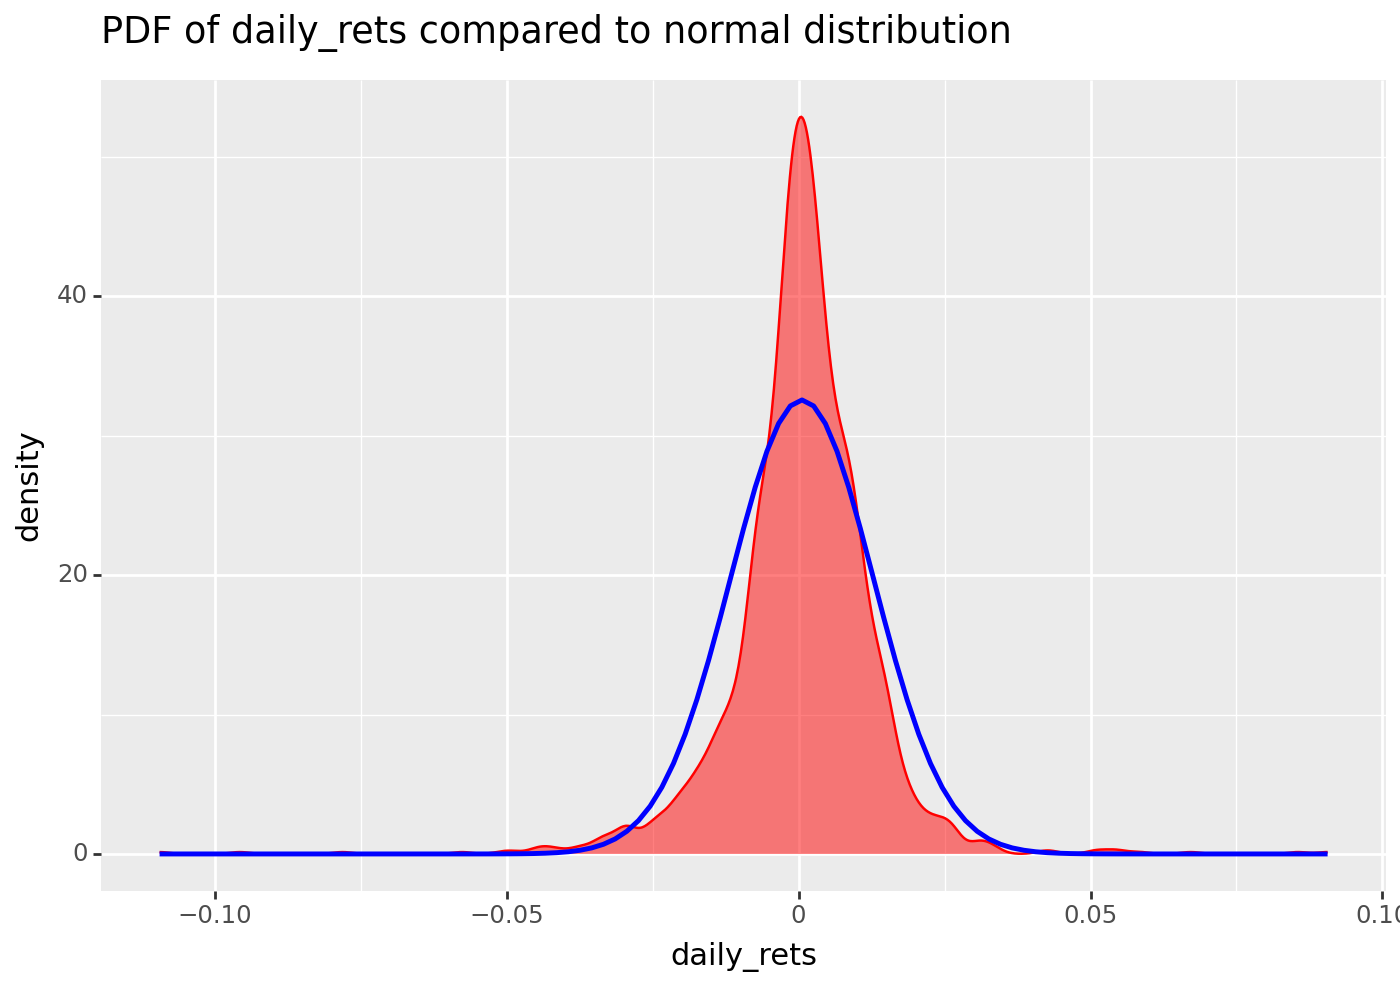

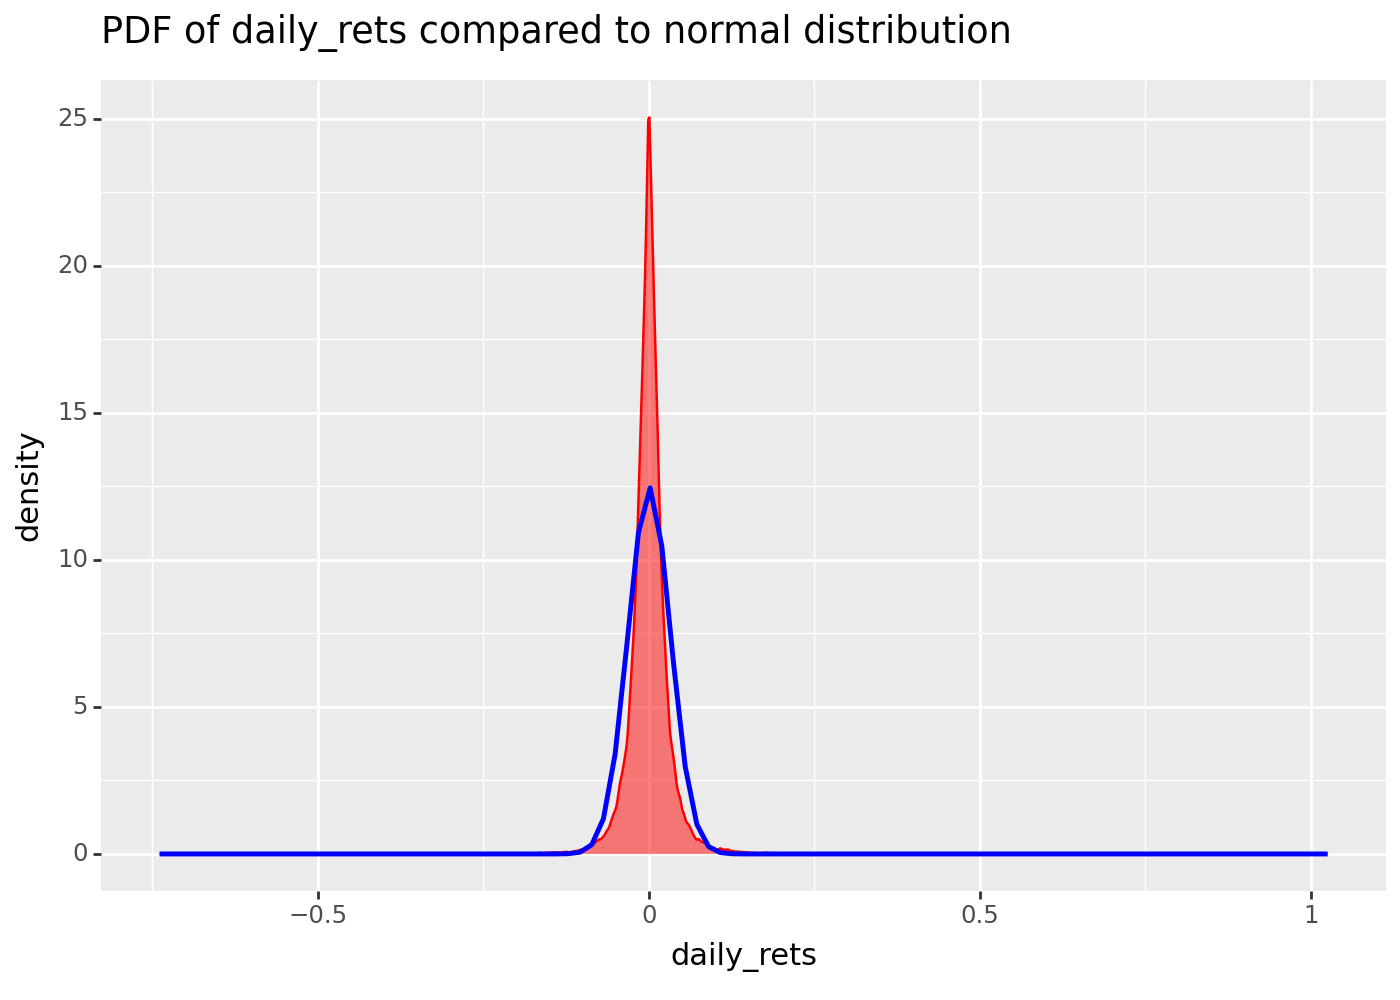

In [14]:
def plot_p9_pdf(data):
    column_name = data.columns[0]
    mean = data.mean().iloc[0]
    std = data.std().iloc[0]

    pdf_plot = (
        ggplot(data, aes(x=column_name)) +
        geom_density(color='red', fill='red', alpha=0.5) +
        stat_function(
            fun=norm.pdf,
            args=(mean, std),
            color='blue',
            size=1
        ) +
        ggtitle(f'PDF of {column_name} compared to normal distribution') +
        theme(figure_size=(7, 5))
    )

    print(pdf_plot)

daily_rets = spy_eod_data['daily_rets']
# daily_rets = daily_rets.sample(60_000)
daily_rets = daily_rets.to_frame()
plot_p9_pdf(daily_rets)


daily_rets = top_eod_data['daily_rets']
daily_rets = daily_rets.sample(60_000)
daily_rets = daily_rets.to_frame()
plot_p9_pdf(daily_rets)

#### **WRDS I/B/E/S Summary History**

​Refinitiv's Institutional Brokers' Estimate System (I/B/E/S) offers a comprehensive database of analyst forecasts and actual earnings data for publicly traded companies worldwide. The "Surprise History" within I/B/E/S specifically focuses on earnings surprises, providing insights into how actual earnings compare to analyst expectations over time.

Key components of the I/B/E/S Surprise History data include:
- Analyst Estimates: Forecasts for various financial metrics, notably Earnings Per Share (EPS), collected from a vast network of analysts. These estimates are aggregated to form consensus figures, serving as benchmarks for actual performance.​
- Actual Reported Earnings: The realized financial figures reported by companies, allowing for direct comparison against prior analyst projections.​


In [ ]:
query_ibes = f"""
    SELECT 
        *
    FROM 
        tr_ibes.surpsum
    WHERE
        1=1
        AND pyear>={year_beginning_filter-1}
        AND fiscalp='QTR'
        AND measure='EPS'
        AND oftic IS NOT NULL
        AND anndats >= '{start_filter_date}'
        AND anndats <= '{end_filter_date}'
"""
surp_sum = db.raw_sql(query_ibes)

# surp_sum.to_parquet(proj_dir/"data/surpsum.parquet")
# surp_sum = pd.read_parquet(proj_dir/"data/surpsum.parquet")


display(surp_sum.head())
display(surp_sum.tail())
display(surp_sum.describe())

,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
0,0001,EPE,EPS,QTR,2017.0,12.0,1,2018-02-28,-0.07,-0.10631,0.03283,1.10621
1,0001,EPE,EPS,QTR,2018.0,3.0,1,2018-05-08,-0.07,-0.06900,0.03739,-0.02675
2,0001,EPE,EPS,QTR,2018.0,6.0,1,2018-08-09,-0.01,0.00936,0.03417,-0.56656
3,0001,EPE,EPS,QTR,2018.0,9.0,1,2018-11-07,-0.04,-0.01083,0.02610,-1.11763
4,0001,EPE,EPS,QTR,2018.0,12.0,1,2019-03-14,-0.13,-0.12973,0.02944,-0.00927


,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
243701,ZZZ,ZZZ,EPS,QTR,2023.0,6.0,0,2023-08-10,0.42,0.48333,0.01966,-3.22078
243702,ZZZ,ZZZ,EPS,QTR,2023.0,9.0,0,2023-11-09,0.76,0.77000,0.07563,-0.13222
243703,ZZZ,ZZZ,EPS,QTR,2023.0,12.0,0,2024-03-06,0.56,0.52500,0.02074,1.68789
243704,ZZZ,ZZZ,EPS,QTR,2024.0,3.0,0,2024-05-07,0.28,0.35833,0.03430,-2.28357
243705,ZZZ,ZZZ,EPS,QTR,2024.0,6.0,0,2024-08-08,0.54,0.35500,0.05323,3.47555


,pyear,pmon,usfirm,actual,surpmean,surpstdev,suescore
count,243706.000000,243706.000000,243706.000000,2.396460e+05,2.437060e+05,175458.000000,170640.000000
mean,2020.809623,7.436144,0.499011,-9.342950e+01,-2.621305e+01,19.369290,1.189340
std,2.029013,3.368904,0.500000,1.821929e+04,7.859336e+03,566.925441,108.096458
min,2017.000000,1.000000,0.000000,-6.556200e+06,-2.115000e+06,0.000000,-10010.134340
25%,2019.000000,4.000000,0.000000,-1.000000e-02,9.025000e-04,0.021210,-0.921475
50%,2021.000000,7.000000,0.000000,3.200000e-01,3.200000e-01,0.056570,0.448930
75%,2023.000000,10.000000,1.000000,1.260000e+00,1.221540e+00,0.183660,2.091550
max,2024.000000,12.000000,1.000000,2.475000e+05,1.202540e+05,183816.960000,25909.274190


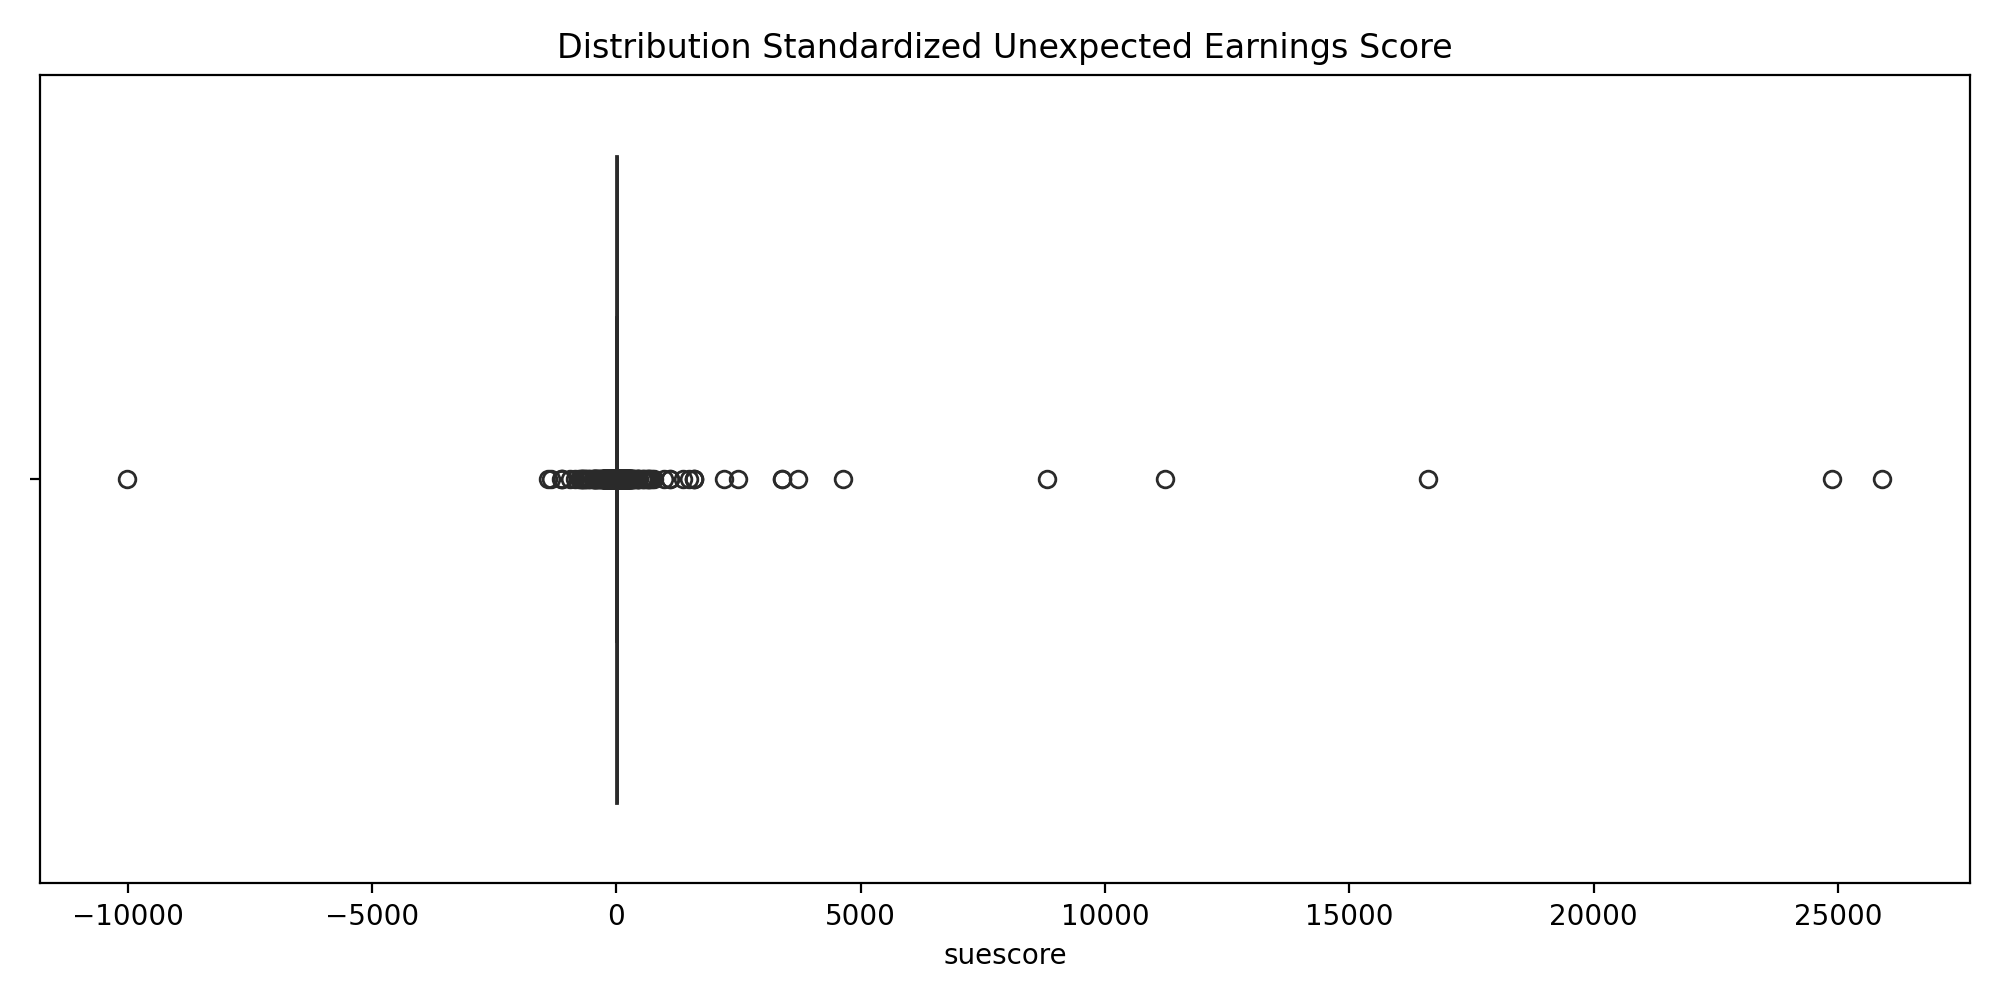

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=surp_sum['suescore'], orient='h', color='darkred')
ax.set_title('Distribution Standardized Unexpected Earnings Score')
plt.tight_layout()
plt.show()

### Data Cleansing/Merge

#### Earnings Surprise Data
Below we are: 
- Converting "anndats" to a proper datetime, dropping any rows where it’s missing.
- Extracting the year from each announcement date, which we will use as a proxy for determining which data is consistent throughout.
- Filtering to keep only tickers that appear in every year of our date range   (year_beginning_filter through year_end_filter).
- Further ensuring each ticker has 4 quarters of data each year for consistently quarterly coverage.
- Removing any ticker that fails these conditions, leaving a final set of tickers meeting both the year coverage and 4-quarter criteria.
- Printing out the number of Investable universe of stocks for this dataset

In [23]:
# Cleaning the surprise Data
surp_sum['anndats'] = pd.to_datetime(surp_sum['anndats'], errors='coerce')
surp_sum = surp_sum[surp_sum['anndats'].notnull()]

surp_sum['year'] = surp_sum['anndats'].dt.year

years_required = set(range(year_beginning_filter, year_end_filter+1))

coverage = surp_sum.groupby('oftic')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda x: years_required.issubset(x))].index
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers)]

quarter_counts = (
    surp_sum
    .groupby(['oftic', 'year'])
    .size()
    .reset_index(name='count_per_year')
)

quarter_counts_ok = quarter_counts[quarter_counts['count_per_year'] >= 4]

annual_coverage = quarter_counts_ok.groupby('oftic')['year'].apply(set)
keep_tickers_4q = annual_coverage[annual_coverage.apply(lambda x: years_required.issubset(x))].index

# Filtering out stocks that dont have 4 quarters of data for each year
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers_4q)]
surp_sum.drop(['ticker'], axis=1, inplace=True)
surp_sum['oftic'].nunique()

3040

##### Integrating Zack's Fundamental B Dataset
Below we are:
- Setting a market value threshold of $500 million to ensure our data stays above that amount throughout the entire date range.
- Calculating new metrics for use in rankings, P/E, EV/EBITDA, and YoY growth in revenue and price
- Ensuring we have consistent quarterly data for all the metrics below
- Printing out the unique amount of filters that pass these filters.
- We then filter the remaining tickers on what we have in the filtered surprise dataset to end up with 327 individual stocks that pass our criteria

In [24]:
zacks_cols = [
    'ticker',
    'per_end_date',
    'per_type',
    'tot_revnu',
    'eps_diluted_net',
    'basic_net_eps',
    'tot_lterm_debt',
    'net_lterm_debt',
    'net_curr_debt',
    'tot_debt_tot_equity',
    'ret_invst',
    'free_cash_flow_per_share',
    'ebitda',
    'shares_out',
    'mkt_val'
]

# Setting The Market Cap Threshold to Filter out Smaller Companies
mkt_cap_threshold = 500

# Selecting the metrics we plan to include in our strategy
zacks_df = zacks_data.loc[zacks_data.ticker.isin(top_tickers_list)].copy()
zacks_df = zacks_df[zacks_df['per_end_date'].notnull() & (zacks_df['per_type'] == 'Q')]
zacks_df.dropna(subset=zacks_cols, inplace=True)
zacks_df.sort_values(['ticker','per_end_date'], inplace=True)

zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filing_date, end_filing_date)]

# Filtering Stocks to a smaller date range
zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filter_date, end_filter_date)]
zacks_df['year'] = zacks_df['per_end_date'].dt.year


years_required = set(range(year_beginning_filter, year_end_filter + 1))
coverage = zacks_df.groupby('ticker')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda s: years_required.issubset(s))].index
zacks_df = zacks_df[zacks_df['ticker'].isin(keep_tickers)]

zacks_df['ticker'].nunique()

266

In [25]:
# Filtering the surprise data on market cap requirement
valid_tickers = set(zacks_df['ticker'].unique())
surp_sum_filtered = surp_sum[surp_sum['oftic'].isin(valid_tickers)].reset_index(drop=True)

surp_sum_filtered['oftic'].nunique()

198

##### Transforming the primary final dataset
Below we are:
- Assign tickers to bins based on their avg_EPS to ensure we are comparing similar magnitudes of percent changes.
- We then transform the daily stock data obtained from the 'QUOTEMEDIA/PRICES' dataset to obtain the next day adjusted close and compute the return between those two days to capture the initial movement of the earnings surprise
- We merge these two datasets and bring in the relevant columns.
- The avg_eps_estimate is then calculated from subtracting the surprise mean from the actual EPS.
- Pct_surprise is calculated as the (average surprise)/ (the next day return)
- We then calculate the primary metric 'surprise_vs_move' which is simply the pct_surprise/(next day return). This should help us gauge how much the stock moved relative to it's surprise number
- The data is then translated into a z-score subtracting the mean of the bin it is in as well as dividing by the standard deviation of the same bin.

In [26]:
# Sorting close prices for merge
eod_data = top_eod_data.loc[top_eod_data.ticker.isin(surp_sum_filtered['oftic'].unique())].copy().reset_index(drop=True)

eod_data['date'] = pd.to_datetime(eod_data['date'])
surp_sum_filtered['anndats'] = pd.to_datetime(surp_sum_filtered['anndats'])

# Merging the surprise data with the EOD data
eod_surp_merged = pd.merge(
    eod_data[['ticker','date','adj_close']],
    surp_sum_filtered,
    how='left',
    left_on=['ticker','date'],
    right_on=['oftic','anndats']    
)

eod_surp_merged = eod_surp_merged.set_index(['ticker', 'date']).groupby(level=0).ffill().reset_index()

In [27]:
display(eod_surp_merged.head())
display(eod_surp_merged.tail())

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year
0,AAOI,2018-01-02,37.91,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,AAOI,2018-01-03,37.89,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,AAOI,2018-01-04,38.38,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,AAOI,2018-01-05,38.89,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,AAOI,2018-01-08,38.37,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year
347078,ZG,2024-12-24,73.80,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0
347079,ZG,2024-12-26,73.66,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0
347080,ZG,2024-12-27,72.74,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0
347081,ZG,2024-12-30,71.30,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0
347082,ZG,2024-12-31,70.85,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0


##### Merging the Fundamentals and Surprise Data
Below we are:
- Transforming the fundamental data and Earnings Surprise to ensure that we have a latest date for both to avoid lookahead bias in trades. To be safe we assume we are only available to trade on this information after the announcement and filing date.
- Both of the datasets are then merged on 'ticker' and 'oftic'.
- Trade day is then calculated as the latest day between the two announcements
- Calculate Z_scores for new metrics within bins
- We then drop incomplete rows and features for a final cleanup.

In [28]:
zacks_df['valid_from'] = zacks_df['filing_date'] + pd.Timedelta(days=1)

fund_data = zacks_df[zacks_cols+['valid_from']].copy()

surp_data = eod_surp_merged.copy()

surp_data_sorted = surp_data.sort_values(by="date")
fund_data_sorted = fund_data.sort_values(by="valid_from")

merged_df = pd.merge(
    surp_data_sorted,
    fund_data_sorted,
    how='left',
    left_on=['ticker','date'],
    right_on=['ticker','valid_from']    
)

merged_df = merged_df.set_index(['ticker', 'date']).groupby(level=0).ffill().reset_index()

In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347083 entries, 0 to 347082
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    347083 non-null  object        
 1   date                      347083 non-null  datetime64[ns]
 2   adj_close                 347083 non-null  float64       
 3   oftic                     341602 non-null  object        
 4   measure                   341602 non-null  object        
 5   fiscalp                   341602 non-null  object        
 6   pyear                     341602 non-null  float64       
 7   pmon                      341602 non-null  float64       
 8   usfirm                    341602 non-null  float64       
 9   anndats                   341602 non-null  datetime64[ns]
 10  actual                    341552 non-null  float64       
 11  surpmean                  341602 non-null  float64       
 12  su

In [30]:
# Identifying tickers that have missing rev_yoy_growth or price_yoy_growth
tickers_with_na = (
    merged_df
    .loc[(merged_df.isna().any(axis=1)) & (merged_df.date>=data_start_date) & (merged_df.date<=data_end_date), 'ticker']
    .unique()
)

# # Dropping all rows belonging to these tickers
merged_df = merged_df[~merged_df['ticker'].isin(tickers_with_na)]

In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230793 entries, 0 to 347082
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    230793 non-null  object        
 1   date                      230793 non-null  datetime64[ns]
 2   adj_close                 230793 non-null  float64       
 3   oftic                     227056 non-null  object        
 4   measure                   227056 non-null  object        
 5   fiscalp                   227056 non-null  object        
 6   pyear                     227056 non-null  float64       
 7   pmon                      227056 non-null  float64       
 8   usfirm                    227056 non-null  float64       
 9   anndats                   227056 non-null  datetime64[ns]
 10  actual                    227056 non-null  float64       
 11  surpmean                  227056 non-null  float64       
 12  surpstd

In [32]:
display(merged_df.describe())
display(merged_df.info())

,date,adj_close,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from
count,230793,230793.000000,227056.000000,227056.000000,227056.000000,227056,227056.000000,227056.000000,227056.000000,227056.000000,227056.000000,215507,215507.000000,215507.000000,215507.000000,215507.000000,215507.000000,215507.000000,215507.000000,215507.000000,215507.00000,215507.000000,215507.000000,2.155070e+05,215507
mean,2021-07-01 15:52:07.930222848,84.531299,2020.732542,7.364426,0.951527,2021-06-07 20:54:11.060531200,1.162991,1.085164,0.088463,1.472103,2020.952853,2021-02-12 12:53:45.161131776,4185.243076,0.739280,0.744396,9290.584239,363.256014,106.728476,2.231460,1.796097,1.89177,858.270674,468.170978,4.452146e+04,2021-03-23 20:37:40.292240896
min,2018-01-02 00:00:00,1.040000,2017.000000,3.000000,0.000000,2018-01-18 00:00:00,-10.440000,-10.523750,0.000000,-94.046100,2018.000000,2018-03-31 00:00:00,-357.000000,-20.960000,-20.960000,0.021000,-17199.000000,-22642.000000,-611.650000,-29.669200,-34.14880,-19305.000000,12.110000,5.410000e+01,2018-04-19 00:00:00
25%,2019-10-02 00:00:00,29.746410,2019.000000,3.000000,1.000000,2019-10-16 00:00:00,0.400000,0.366520,0.023940,-0.169740,2019.000000,2019-06-30 00:00:00,677.186000,0.210000,0.210000,1369.085000,-42.736000,-88.000000,0.628100,0.562700,-0.48390,87.238000,67.810000,2.912230e+03,2019-08-09 00:00:00
50%,2021-07-01 00:00:00,55.357913,2021.000000,6.000000,1.000000,2021-05-10 00:00:00,0.830000,0.765250,0.045860,1.032790,2021.000000,2020-12-31 00:00:00,1566.000000,0.690000,0.695000,3444.000000,-0.039000,0.640000,1.153700,1.628400,0.99740,257.000000,156.680000,8.446550e+03,2021-01-28 00:00:00
75%,2023-03-31 00:00:00,109.348683,2022.000000,9.000000,1.000000,2023-02-22 00:00:00,1.530000,1.461180,0.098070,2.788590,2023.000000,2022-09-30 00:00:00,4075.000000,1.310000,1.320000,10171.000000,511.000000,138.000000,1.933000,3.133600,3.16630,851.000000,384.350000,2.739779e+04,2022-11-03 00:00:00
max,2024-12-31 00:00:00,958.350400,2024.000000,12.000000,1.000000,2024-11-14 00:00:00,17.180000,12.894400,3.795910,366.978960,2024.000000,2024-09-30 00:00:00,91819.000000,16.280000,16.280000,105752.000000,27380.000000,48256.900000,459.480300,37.681200,92.21620,28385.000000,19319.720000,2.263972e+06,2024-11-22 00:00:00
std,NaN,87.820422,2.015266,3.279165,0.214763,NaN,1.455880,1.323152,0.163909,6.761429,1.977999,NaN,8578.002959,2.266095,2.287472,15276.559375,2031.652611,2370.720554,18.630335,5.280147,6.92159,2461.151782,1534.063240,1.674194e+05,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 230793 entries, 0 to 347082
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    230793 non-null  object        
 1   date                      230793 non-null  datetime64[ns]
 2   adj_close                 230793 non-null  float64       
 3   oftic                     227056 non-null  object        
 4   measure                   227056 non-null  object        
 5   fiscalp                   227056 non-null  object        
 6   pyear                     227056 non-null  float64       
 7   pmon                      227056 non-null  float64       
 8   usfirm                    227056 non-null  float64       
 9   anndats                   227056 non-null  datetime64[ns]
 10  actual                    227056 non-null  float64       
 11  surpmean                  227056 non-null  float64       
 12  surpstd

None

In [ ]:
# merged_df.to_parquet('../data/merged_data.parquet')
# merged_df = pd.read_parquet('../data/merged_data.parquet')

## **Feature Engineering**

To capture disposition effect and underreaction to news, we will constrcut factors incorporating fundamental, earnings, and price data.

1. Disposition Effect Signals
- Capital Gains Overhang:
    - Compute unrealized capital gains/losses using mutual fund holdings (due to limited data we are using a reference price instaed) and stock price history.
    - $CGO = (Current Price - Weighted Average Purchase Price) / Current Price$
    - Stocks with large unrealized losses tend to underreact to bad news.
- Realized vs. Unrealized Gains Ratio:
    - High values: Investors aggressively taking profits (possible reversal).
    - Low values: Investors reluctant to realize losses (potential underreaction).

2. PEAD Signals
- Earnings Surprise (SUE - Standardized Unexpected Earnings):
    - $SUE = (Actual\ EPS - Expected\ EPS) / Std\ of\ EPS\ Estimates$
    - Higher SUE: Stronger PEAD effects
- Earnings Drift Factor:
    - Stocks with high past earnings surprise but low short-term reaction may exhibit PEAD.
    - Compute cumulative abnormal returns (CAR) post-earnings
        - We will test different window lengths (5-day, 30-day, etc)

3. Momentum & Technical Signals
- N-Month Momentum: Stocks with strong past N-month returns tend to continue moving in the same direction.
- Relative Strength Index: Captures overbought/oversold condition
    - We will test different windows here
- Short-Term Reversals: Compute N-week return to detect extreme short-term movements

4. Fundamentals


\begin{array}{|l|l|l|}
\hline
\textbf{Feature Name} & \textbf{Definition} & \textbf{Purpose} \\
\hline
ps\ ratio & \text{Market Value / Total Revenue} & \text{Valuation} \\
earnings\ yield & \text{EPS / Market Value per Share} & \text{Valuation} \\
fcf\ yield & \text{Free Cash Flow per Share / Market Value per Share} & \text{Valuation} \\
ebitda\ margin & \text{EBITDA / Total Revenue} & \text{Profitability} \\
roi\ scaled & \text{Return on Investment} & \text{Profitability} \\
eps\ growth & \text{YoY EPS Growth} & \text{Growth} \\
debt\ to\ equity & \text{Total Debt / Total Equity} & \text{Leverage} \\
net\ debt\ to\ ebitda & \text{(Net LT Debt + Net Current Debt) / EBITDA} & \text{Leverage} \\
debt\ to\ revenue & \text{Total LT Debt / Total Revenue} & \text{Leverage} \\
revenue\ growth & \text{YoY Revenue Growth} & \text{Growth} \\
ebitda\ growth & \text{YoY EBITDA Growth} & \text{Growth} \\
mkt\ cap\ growth & \text{YoY Market Cap Growth} & \text{Growth} \\
log\ mkt\ cap & \text{Log of Market Cap} & \text{Size Indicator} \\
fcf\ growth & \text{YoY Free Cash Flow Growth} & \text{Growth} \\
\hline
\end{array}

In [199]:
display(merged_df.head())
display(merged_df.tail())

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from
0,AAOI,2018-01-02,37.910000,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,SCI,2018-01-02,33.605937,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,CCI,2018-01-02,81.755975,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,CAT,2018-01-02,133.901045,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
6,CACI,2018-01-02,134.150000,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from
347078,CAT,2024-12-31,362.76,CAT,EPS,QTR,2024.0,9.0,1.0,2024-10-30,5.17,5.33672,0.16314,-1.02195,2024.0,2024-09-30,Q,16106.000,5.06,5.09,25784.0,717.0000,-848.0,1.9534,5.4507,14.3929,4026.000,482.80,188833.70,2024-11-08
347079,SBUX,2024-12-31,91.25,SBUX,EPS,QTR,2024.0,9.0,1.0,2024-10-30,0.80,1.02804,0.03286,-6.94071,2024.0,2024-09-30,Q,9073.999,0.80,0.80,14319.5,170.2001,-33.7,-2.0921,13.2264,2.9175,1708.401,1133.20,110475.66,2024-11-22
347080,CCI,2024-12-31,90.76,CCI,EPS,QTR,2024.0,9.0,1.0,2024-10-16,0.70,0.66592,0.05014,0.67962,2024.0,2024-09-30,Q,1652.000,0.70,0.70,23452.0,423.0000,642.0,4.5436,1.0540,2.5688,982.000,434.60,51556.38,2024-11-01
347081,CCK,2024-12-31,82.69,CCK,EPS,QTR,2024.0,9.0,1.0,2024-10-17,1.99,1.80107,0.02131,8.86614,2024.0,2024-06-30,Q,3040.000,1.45,1.45,5949.0,-40.0000,80.0,2.4891,2.3191,1.5609,494.000,120.64,8974.45,2024-07-31
347082,ZG,2024-12-31,70.85,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0,2024-09-30,Q,581.000,-0.08,-0.08,497.0,-697.0000,55.0,0.2283,-0.3881,0.8472,26.000,233.56,14464.32,2024-11-08


In [200]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230793 entries, 0 to 347082
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    230793 non-null  object        
 1   date                      230793 non-null  datetime64[ns]
 2   adj_close                 230793 non-null  float64       
 3   oftic                     227056 non-null  object        
 4   measure                   227056 non-null  object        
 5   fiscalp                   227056 non-null  object        
 6   pyear                     227056 non-null  float64       
 7   pmon                      227056 non-null  float64       
 8   usfirm                    227056 non-null  float64       
 9   anndats                   227056 non-null  datetime64[ns]
 10  actual                    227056 non-null  float64       
 11  surpmean                  227056 non-null  float64       
 12  surpstd

In [201]:
# Define window for reference price
window = 65

# Compute rolling average price (proxy for purchase price)
merged_df['ref_price'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: x.rolling(window).mean())

# Compute Capital Gains Overhang
merged_df['cgo'] = (merged_df['adj_close'] - merged_df['ref_price']) / merged_df['adj_close']

In [202]:
# Define rolling window lengths
momentum_windows = [21, 126, 252]  # 1-month, 6-month, 12-month

# Compute momentum factors (log returns)
for window in momentum_windows:
    merged_df[f'mom_{window}'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: np.log(x / x.shift(window)))

# Compute short-term reversal (1-week return)
merged_df['short_term_reversal'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: np.log(x / x.shift(5)))

In [203]:
# Compute cumulative abnormal return (CAR) post earnings
windows = [5, 20]  # 5-day and 30-day drift

for w in windows:
    merged_df[f'pead_{w}d'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: x.pct_change(w))

In [204]:
merged_df['ps_ratio'] = merged_df['mkt_val'] / merged_df['tot_revnu']
merged_df['earnings_yield'] = merged_df['eps_diluted_net'] / (merged_df['mkt_val'] / merged_df['shares_out'])
merged_df['fcf_yield'] = merged_df['free_cash_flow_per_share'] / (merged_df['mkt_val'] / merged_df['shares_out'])
merged_df['ebitda_margin'] = merged_df['ebitda'] / merged_df['tot_revnu']
merged_df['roi_scaled'] = merged_df['ret_invst'] / 100
merged_df['eps_growth'] = merged_df.groupby('ticker')['eps_diluted_net'].pct_change(4)
merged_df['net_debt_to_ebitda'] = (merged_df['net_lterm_debt'] + merged_df['net_curr_debt']) / merged_df['ebitda']
merged_df['debt_to_revenue'] = merged_df['tot_lterm_debt'] / merged_df['tot_revnu']
merged_df['revenue_growth'] = merged_df.groupby('ticker')['tot_revnu'].pct_change(4)
merged_df['ebitda_growth'] = merged_df.groupby('ticker')['ebitda'].pct_change(4)
merged_df['mkt_cap_growth'] = merged_df.groupby('ticker')['mkt_val'].pct_change(4)
merged_df['log_mkt_cap'] = np.log(merged_df['mkt_val'])
merged_df['fcf_growth'] = merged_df.groupby('ticker')['free_cash_flow_per_share'].pct_change(4)

In [205]:
prediction_target_windows = [5, 20, 60]
feature_importance_dict = {}

for w in prediction_target_windows:
    prediction_target_window = w
    merged_df[f'target_return_{w}_day'] = merged_df.groupby('ticker')['adj_close'].pct_change(w)
    merged_df[f'target_return_{w}_day'] = merged_df.groupby('ticker')[f'target_return_{w}_day'].shift(-w)

In [206]:
merged_df['day_after_earnings']= merged_df.groupby(['ticker', 'anndats'])['date'].nth(1)
merged_df['day_after_earnings'] = merged_df.groupby('ticker')['day_after_earnings'].ffill()
merged_df['previous_day_return'] = merged_df.groupby('ticker')['adj_close'].pct_change()
merged_df[merged_df['ticker']=='AAPL'][['date','anndats', 'day_after_earnings']].tail(20)

,date,anndats,day_after_earnings
343239,2024-12-03,2024-10-31,2024-11-01
343341,2024-12-04,2024-10-31,2024-11-01
343631,2024-12-05,2024-10-31,2024-11-01
343873,2024-12-06,2024-10-31,2024-11-01
344031,2024-12-09,2024-10-31,2024-11-01
344321,2024-12-10,2024-10-31,2024-11-01
344444,2024-12-11,2024-10-31,2024-11-01
344534,2024-12-12,2024-10-31,2024-11-01
344764,2024-12-13,2024-10-31,2024-11-01
345068,2024-12-16,2024-10-31,2024-11-01


In [207]:
final_df = merged_df.loc[(merged_df['date']>=data_start_date) & (merged_df['date']<=data_end_date) & (merged_df['day_after_earnings']==merged_df['date'])].copy().reset_index(drop=True).sort_values(by=['ticker','date'])
trading_data = merged_df.loc[(merged_df['date']>=data_start_date) & (merged_df['date']<=data_end_date)].copy().reset_index(drop=True).sort_values(by=['ticker','date'])
final_df = final_df.dropna(subset=[f'target_return_{w}_day' for w in prediction_target_windows])
display(final_df.head())
display(final_df.tail())
display(final_df.describe())

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from,ref_price,cgo,mom_21,mom_126,mom_252,short_term_reversal,pead_5d,pead_20d,ps_ratio,earnings_yield,fcf_yield,ebitda_margin,roi_scaled,eps_growth,net_debt_to_ebitda,debt_to_revenue,revenue_growth,ebitda_growth,mkt_cap_growth,log_mkt_cap,fcf_growth,target_return_5_day,target_return_20_day,target_return_60_day,day_after_earnings,previous_day_return
105,AAOI,2019-02-22,15.42,AAOI,EPS,QTR,2018.0,12.0,1.0,2019-02-21,-0.02,-0.03778,0.03232,0.55009,2019.0,2018-06-30,Q,87.822,0.40,0.41,57.868,25.463,-14.000,0.1781,2.0060,-0.6377,16.270,19.58,879.10,2018-08-10,17.092538,-0.108466,-0.049963,-0.968349,-0.806742,0.046458,0.047554,-0.077751,10.010020,0.008909,-0.014203,0.185261,0.020060,0.0,0.704548,0.658924,0.0,0.0,0.0,6.778899,0.0,-0.141375,-0.175746,-0.398833,2019-02-22,0.056164
258,AAOI,2019-05-09,10.93,AAOI,EPS,QTR,2019.0,3.0,1.0,2019-05-08,-0.27,-0.21667,0.01871,-2.85083,2019.0,2018-12-31,Q,58.018,-0.43,-0.43,60.328,44.716,-5.896,0.2550,-2.2002,-2.9077,-4.344,19.80,305.49,2019-02-28,13.417231,-0.227560,-0.098383,-0.575821,-1.167544,-0.100867,-0.095947,-0.111382,5.265435,-0.027870,-0.188459,-0.074873,-0.022002,0.0,-8.936464,1.039815,0.0,0.0,0.0,5.721917,0.0,-0.111619,-0.130833,-0.103385,2019-05-09,-0.093698
401,AAOI,2019-08-08,10.90,AAOI,EPS,QTR,2019.0,6.0,1.0,2019-08-07,-0.26,-0.37333,0.01658,6.83431,2019.0,2018-12-31,Q,58.018,-0.43,-0.43,60.328,44.716,-5.896,0.2550,-2.2002,-2.9077,-4.344,19.80,305.49,2019-02-28,9.608769,0.118462,0.055648,-0.372828,-1.228352,0.093202,0.097684,0.101010,5.265435,-0.027870,-0.188459,-0.074873,-0.022002,0.0,-8.936464,1.039815,0.0,0.0,0.0,5.721917,0.0,-0.185321,-0.055046,-0.122018,2019-08-08,0.067581
535,AAOI,2019-11-07,10.69,AAOI,EPS,QTR,2019.0,9.0,1.0,2019-11-06,-0.15,-0.23967,0.01769,5.06820,2019.0,2018-12-31,Q,58.018,-0.43,-0.43,60.328,44.716,-5.896,0.2550,-2.2002,-2.9077,-4.344,19.80,305.49,2019-02-28,10.266077,0.039656,0.028465,-0.001869,-0.641312,0.132863,0.142094,0.052165,5.265435,-0.027870,-0.188459,-0.074873,-0.022002,0.0,-8.936464,1.039815,0.0,0.0,0.0,5.721917,0.0,0.019645,-0.029935,0.134705,2019-11-07,-0.087105
692,AAOI,2020-02-28,8.93,AAOI,EPS,QTR,2019.0,12.0,1.0,2020-02-27,-0.18,-0.23350,0.01634,3.27457,2020.0,2018-12-31,Q,58.018,-0.43,-0.43,60.328,44.716,-5.896,0.2550,-2.2002,-2.9077,-4.344,19.80,305.49,2019-02-28,11.768462,-0.317857,-0.289640,0.029548,-0.413273,-0.233615,-0.208333,-0.233476,5.265435,-0.027870,-0.188459,-0.074873,-0.022002,0.0,-8.936464,1.039815,0.0,0.0,0.0,5.721917,0.0,-0.015677,-0.162374,0.003359,2020-02-28,-0.065900


,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from,ref_price,cgo,mom_21,mom_126,mom_252,short_term_reversal,pead_5d,pead_20d,ps_ratio,earnings_yield,fcf_yield,ebitda_margin,roi_scaled,eps_growth,net_debt_to_ebitda,debt_to_revenue,revenue_growth,ebitda_growth,mkt_cap_growth,log_mkt_cap,fcf_growth,target_return_5_day,target_return_20_day,target_return_60_day,day_after_earnings,previous_day_return
2595,ZG,2023-08-03,53.55,ZG,EPS,QTR,2023.0,6.0,1.0,2023-08-02,0.39,0.17869,0.07052,2.99653,2023.0,2022-12-31,Q,435.0,-0.31,-0.31,1660.0,-1158.0,-2282.0,0.3786,-1.1723,18.5781,-32.0,234.27,7311.5,2023-02-17,47.837077,0.106684,0.102770,0.200982,0.375390,0.043900,0.044878,0.156088,16.808046,-0.009933,0.595267,-0.073563,-0.011723,0.0,107.5,3.816092,0.0,0.0,0.0,8.897204,0.0,0.020542,-0.049113,-0.295425,2023-08-03,0.009806
2720,ZG,2023-11-02,34.74,ZG,EPS,QTR,2023.0,9.0,1.0,2023-11-01,0.33,0.21619,0.07884,1.44362,2023.0,2022-12-31,Q,435.0,-0.31,-0.31,1660.0,-1158.0,-2282.0,0.3786,-1.1723,18.5781,-32.0,234.27,7311.5,2023-02-17,45.975231,-0.323409,-0.203258,-0.278138,0.115196,-0.070029,-0.067633,-0.181047,16.808046,-0.009933,0.595267,-0.073563,-0.011723,0.0,107.5,3.816092,0.0,0.0,0.0,8.897204,0.0,0.012953,0.198906,0.585780,2023-11-02,-0.029338
2860,ZG,2024-02-14,56.03,ZG,EPS,QTR,2023.0,12.0,1.0,2024-02-13,0.20,0.11647,0.05385,1.55129,2024.0,2022-12-31,Q,435.0,-0.31,-0.31,1660.0,-1158.0,-2282.0,0.3786,-1.1723,18.5781,-32.0,234.27,7311.5,2023-02-17,49.715538,0.112698,0.091125,0.045832,0.238294,0.008604,0.008641,0.107531,16.808046,-0.009933,0.595267,-0.073563,-0.011723,0.0,107.5,3.816092,0.0,0.0,0.0,8.897204,0.0,-0.085311,-0.051580,-0.253971,2024-02-14,0.076258
2999,ZG,2024-05-02,39.19,ZG,EPS,QTR,2024.0,3.0,1.0,2024-05-01,0.36,0.32400,0.05510,0.65332,2024.0,2022-12-31,Q,435.0,-0.31,-0.31,1660.0,-1158.0,-2282.0,0.3786,-1.1723,18.5781,-32.0,234.27,7311.5,2023-02-17,49.243538,-0.256533,-0.156954,0.098044,-0.072101,-0.078963,-0.075925,-0.144883,16.808046,-0.009933,0.595267,-0.073563,-0.011723,0.0,107.5,3.816092,0.0,0.0,0.0,8.897204,0.0,0.083440,0.024496,0.218423,2024-05-02,-0.054295
3184,ZG,2024-08-08,47.70,ZG,EPS,QTR,2024.0,6.0,1.0,2024-08-07,0.39,0.26909,0.02072,5.83679,2024.0,2022-12-31,Q,435.0,-0.31,-0.31,1660.0,-1158.0,-2282.0,0.3786,-1.1723,18.5781,-32.0,234.27,7311.5,2023-02-17,44.604923,0.064886,0.036290,-0.152352,-0.148022,0.072142,0.074808,-0.013444,16.808046,-0.009933,0.595267,-0.073563,-0.011723,0.0,107.5,3.816092,0.0,0.0,0.0,8.897204,0.0,0.079665,0.080294,0.209015,2024-08-08,0.182156


,date,adj_close,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from,ref_price,cgo,mom_21,mom_126,mom_252,short_term_reversal,pead_5d,pead_20d,ps_ratio,earnings_yield,fcf_yield,ebitda_margin,roi_scaled,eps_growth,net_debt_to_ebitda,debt_to_revenue,revenue_growth,ebitda_growth,mkt_cap_growth,log_mkt_cap,fcf_growth,target_return_5_day,target_return_20_day,target_return_60_day,day_after_earnings,previous_day_return
count,3212,3212.000000,3212.000000,3212.000000,3212.000000,3212,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3.212000e+03,3212,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3188.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212,3212.000000
mean,2021-11-04 15:03:48.642590464,88.298678,2021.130448,7.438356,0.918431,2021-11-03 12:57:49.987546624,1.188448,1.112621,0.098198,1.473302,2021.392590,2021-02-13 22:00:17.932752384,4337.703519,0.755882,0.761728,9502.159514,376.290903,92.751224,2.109319,1.739610,2.026525,847.611070,471.067889,4.459074e+04,2021-03-25 23:47:53.723536640,86.916117,0.002480,0.022934,0.030936,0.053593,0.001355,0.004528,0.028513,9.458085,-0.001421,0.015666,0.198318,0.017396,-0.008208,1.008041,4.519251,0.000164,0.002628,0.000111,9.213782,-0.107002,0.005049,0.009568,0.033605,2021-11-04 15:03:48.642590464,0.000406
min,2019-01-18 00:00:00,1.340000,2018.000000,3.000000,0.000000,2019-01-18 00:00:00,-7.690000,-6.687140,0.000000,-94.046100,2019.000000,2018-03-31 00:00:00,-357.000000,-20.960000,-20.960000,0.021000,-17199.000000,-22642.000000,-611.650000,-29.669200,-34.148800,-19305.000000,12.110000,5.410000e+01,2018-04-19 00:00:00,1.358923,-2.299473,-0.880498,-1.668826,-3.535551,-0.525560,-0.408776,-0.545407,-157.211092,-1.304158,-1.549965,-5.477647,-0.296692,-20.086957,-557.856644,-16.226891,-0.190122,-0.635753,-0.400198,3.990834,-329.400000,-0.584317,-0.802574,-0.801796,2019-01-18 00:00:00,-0.389547
25%,2020-05-07 00:00:00,30.143750,2020.000000,3.000000,1.000000,2020-05-06 00:00:00,0.390000,0.353375,0.025773,-0.235235,2020.000000,2019-09-30 00:00:00,701.399000,0.200000,0.210000,1529.673000,-45.158500,-98.250000,0.626950,0.531775,-0.453400,94.111000,69.390000,3.080060e+03,2019-11-01 00:00:00,29.841543,-0.045877,-0.035464,-0.090220,-0.111774,-0.036859,-0.036188,-0.034899,3.389330,0.004361,-0.010095,0.103696,0.005318,0.000000,-0.427617,1.077189,0.000000,0.000000,0.000000,8.032704,0.000000,-0.021623,-0.042830,-0.063821,2020-05-07 00:00:00,-0.018927
50%,2021-11-03 00:00:00,57.646342,2021.000000,6.000000,1.000000,2021-11-02 00:00:00,0.830000,0.763230,0.050000,1.024985,2021.000000,2020-12-31 00:00:00,1576.500000,0.690000,0.700000,3576.391500,4.000000,0.640000,1.163400,1.614650,1.030700,269.369500,156.340000,8.902010e+03,2021-02-11 00:00:00,56.788260,0.016465,0.022977,0.037287,0.060859,0.004058,0.004066,0.022100,6.962398,0.010566,0.016119,0.183721,0.016147,0.000000,0.240968,1.900009,0.000000,0.000000,0.000000,9.094032,0.000000,0.004214,0.011478,0.026136,2021-11-03 00:00:00,0.000000
75%,2023-04-28 00:00:00,113.298888,2023.000000,12.000000,1.000000,2023-04-27 00:00:00,1.540000,1.466565,0.107717,2.804570,2023.000000,2022-06-30 00:00:00,4167.708250,1.300000,1.310000,10824.000000,640.900000,135.050000,1.894700,3.101575,3.183550,858.250000,388.660000,2.773289e+04,2022-08-10 00:00:00,112.841039,0.066655,0.081505,0.164695,0.228511,0.042379,0.043290,0.081312,12.548256,0.017633,0.047885,0.305512,0.031016,0.000000,1.606076,4.696158,0.000000,0.000000,0.000000,10.230374,0.000000,0.031219,0.060069,

In [208]:
req_cols = [
    'ticker',
    'date',
    'adj_close'
]
features = [
    'suescore',
    'cgo', 
    'mom_21', 'mom_126', 'mom_252','short_term_reversal', 
    'pead_5d', 'pead_20d', 
    'ps_ratio','earnings_yield', 'fcf_yield', 'ebitda_margin', 'roi_scaled',
    'net_debt_to_ebitda', 'debt_to_revenue', 'revenue_growth',
    'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap', 'fcf_growth'
]

#### HH model

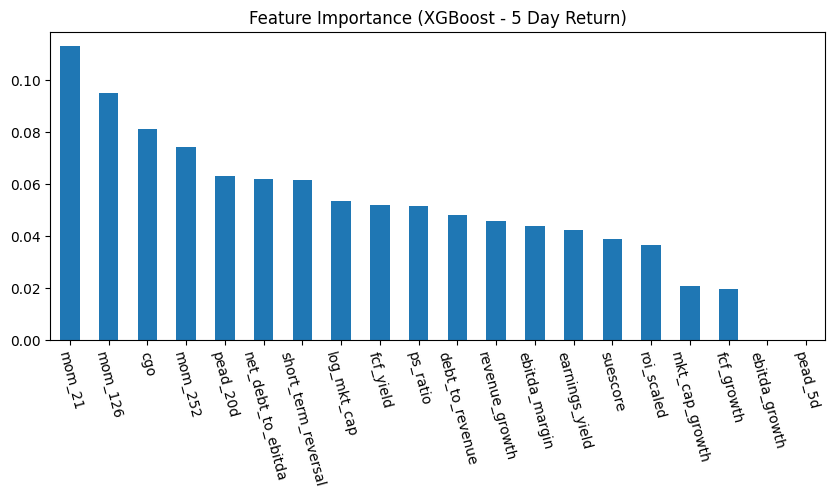

Top 10 Important Features: ['mom_21', 'mom_126', 'cgo', 'mom_252', 'pead_20d', 'net_debt_to_ebitda', 'short_term_reversal', 'log_mkt_cap', 'fcf_yield', 'ps_ratio']


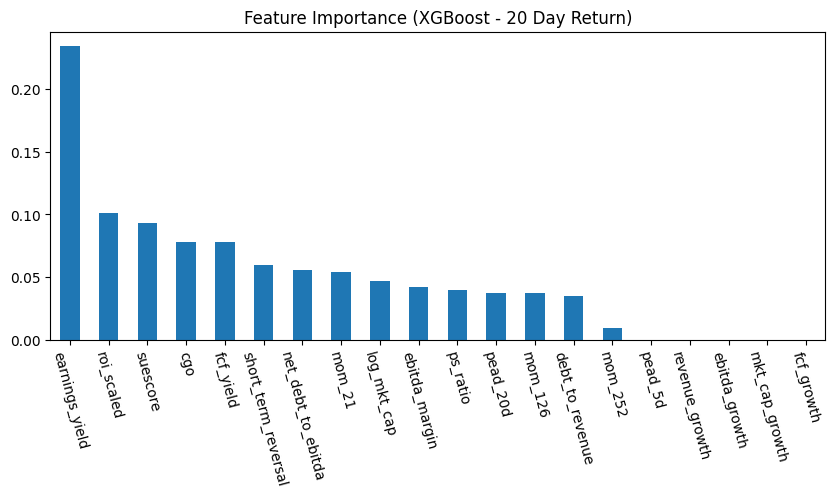

Top 10 Important Features: ['earnings_yield', 'roi_scaled', 'suescore', 'cgo', 'fcf_yield', 'short_term_reversal', 'net_debt_to_ebitda', 'mom_21', 'log_mkt_cap', 'ebitda_margin']


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [86]:
prediction_target_windows = [5, 20, 60]
feature_importance_dict = {}

ml_data = final_df.copy()

for w in prediction_target_windows:
    prediction_target_window = w

    ml_data['target_return'] = ml_data.groupby('ticker')['adj_close'].pct_change(prediction_target_window).shift(-prediction_target_window)

    ml_data.dropna(subset=['target_return'], inplace=True)

    ml_data = ml_data.dropna(subset=features + ['target_return'])

    X = ml_data[features]
    y = ml_data['target_return']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    feature_importance = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

    feature_importance_dict[w] = feature_importance

    plt.figure(figsize=(10, 4))
    feature_importance.plot(kind='bar')
    plt.xticks(rotation=-75) 
    plt.title(f"Feature Importance (XGBoost - {w} Day Return)")
    plt.show()

    top_features = feature_importance.index[:10].tolist()
    print("Top 10 Important Features:", top_features)

#### SC model

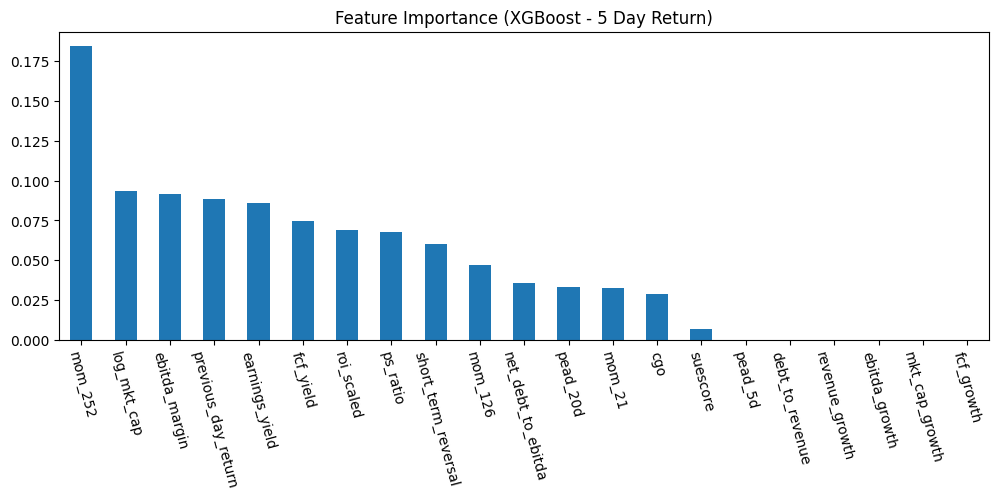

Top 10 Important Features: ['mom_252', 'log_mkt_cap', 'ebitda_margin', 'previous_day_return', 'earnings_yield', 'fcf_yield', 'roi_scaled', 'ps_ratio', 'short_term_reversal', 'mom_126']


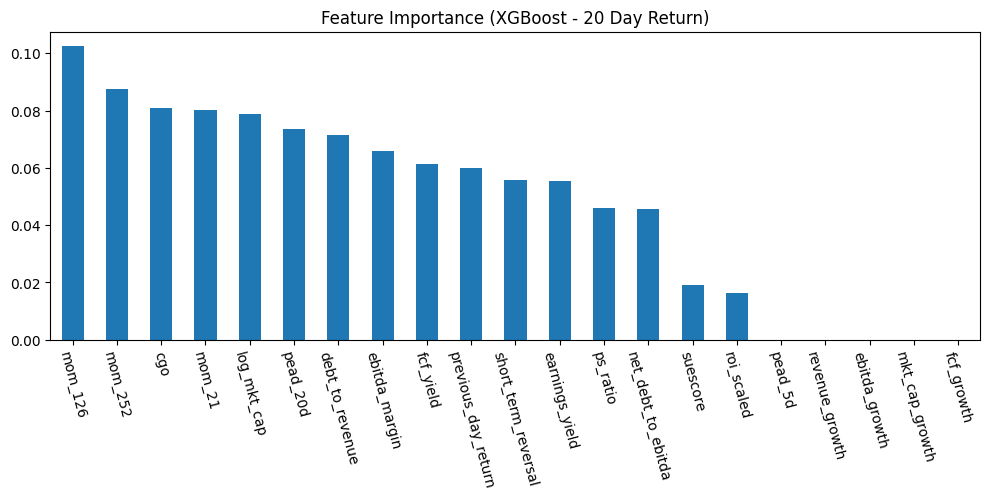

Top 10 Important Features: ['mom_126', 'mom_252', 'cgo', 'mom_21', 'log_mkt_cap', 'pead_20d', 'debt_to_revenue', 'ebitda_margin', 'fcf_yield', 'previous_day_return']


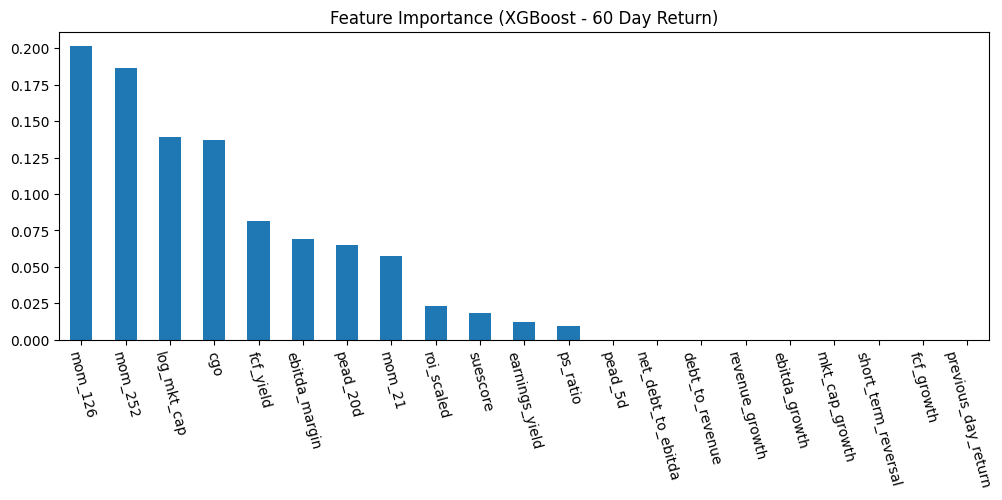

Top 10 Important Features: ['mom_126', 'mom_252', 'log_mkt_cap', 'cgo', 'fcf_yield', 'ebitda_margin', 'pead_20d', 'mom_21', 'roi_scaled', 'suescore']


In [209]:
validation_set = final_df.loc[final_df['date']>=pd.to_datetime('2024-01-01')].copy()
in_sample = final_df.loc[final_df['date']<pd.to_datetime('2024-01-01')].copy()
test_size = int(np.floor(len(in_sample) * 0.1))
test_set = in_sample.iloc[-test_size:]
training_set = in_sample.iloc[:-test_size]

req_cols = [
    'ticker',
    'date',
    'adj_close'
]
features = [
    'suescore',
    'cgo', 
    'mom_21', 'mom_126', 'mom_252','short_term_reversal', 
    'pead_5d', 'pead_20d', 
    'ps_ratio','earnings_yield', 'fcf_yield', 'ebitda_margin', 'roi_scaled',
    'net_debt_to_ebitda', 'debt_to_revenue', 'revenue_growth',
    'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap', 'fcf_growth', 'previous_day_return'
]
for w in prediction_target_windows:   
    
    test_size = int(np.floor(len(in_sample) * 0.1))
    X_train = training_set[features]
    y_train = training_set[f'target_return_{w}_day']
    X_test = test_set[features]
    y_test = test_set[f'target_return_{w}_day']
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = xgb.XGBRegressor(n_estimators=10, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    feature_importance = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

    feature_importance_dict[w] = feature_importance

    plt.figure(figsize=(12, 4))
    feature_importance.plot(kind='bar')
    plt.xticks(rotation=-75) 
    plt.title(f"Feature Importance (XGBoost - {w} Day Return)")
    plt.show()

    top_features = feature_importance.index[:10].tolist()
    print("Top 10 Important Features:", top_features)


## Data Analysis

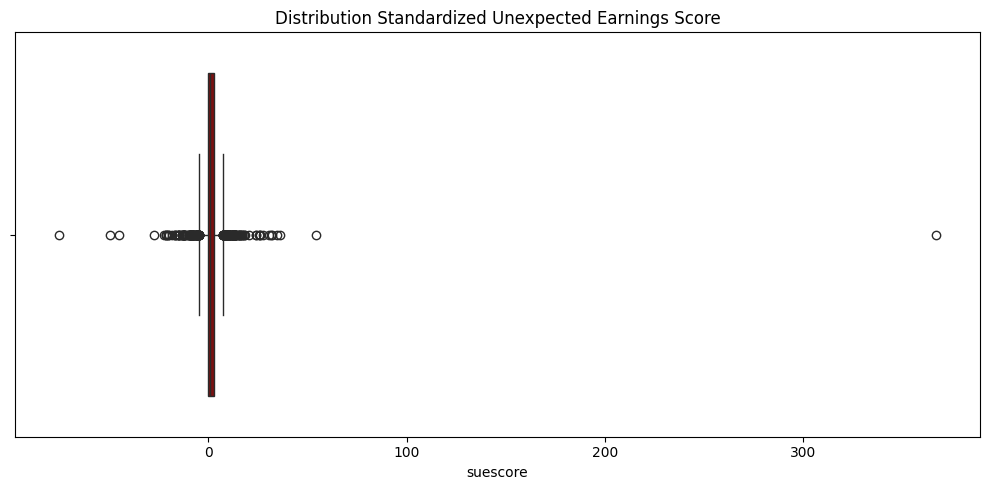

In [210]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=training_set['suescore'], orient='h', color='darkred')
ax.set_title('Distribution Standardized Unexpected Earnings Score')
plt.tight_layout()
plt.show()

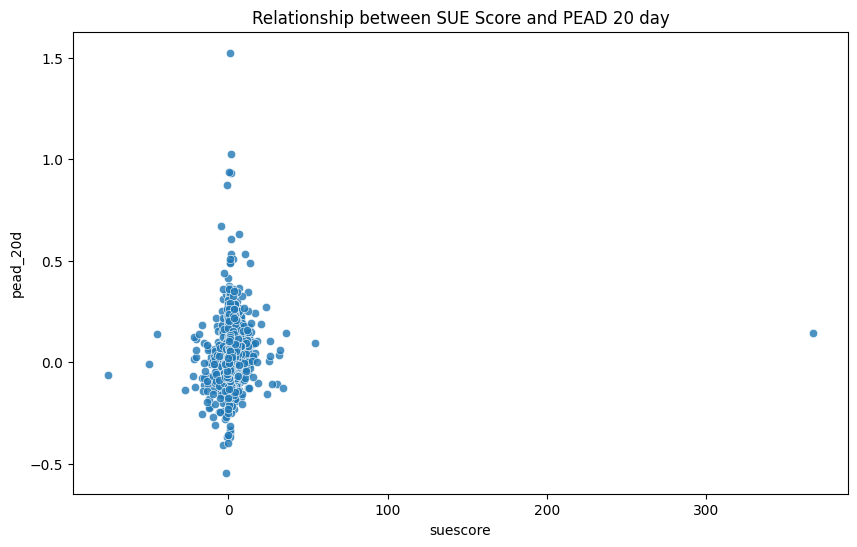

In [211]:
plt.figure(figsize=(10, 6))

plot_df = training_set.copy()

sns.scatterplot(
    x='suescore', 
    y='pead_20d', 
    data=plot_df, 
    palette='tab10',
    alpha=0.8  
)

plt.xlabel('suescore')
plt.ylabel('pead_20d')
plt.title('Relationship between SUE Score and PEAD 20 day')

plt.show()

sue_quantile
Low    -0.003553
Q2      0.024739
Q3      0.034707
Q4      0.039999
High    0.061063
Name: pead_20d, dtype: float64


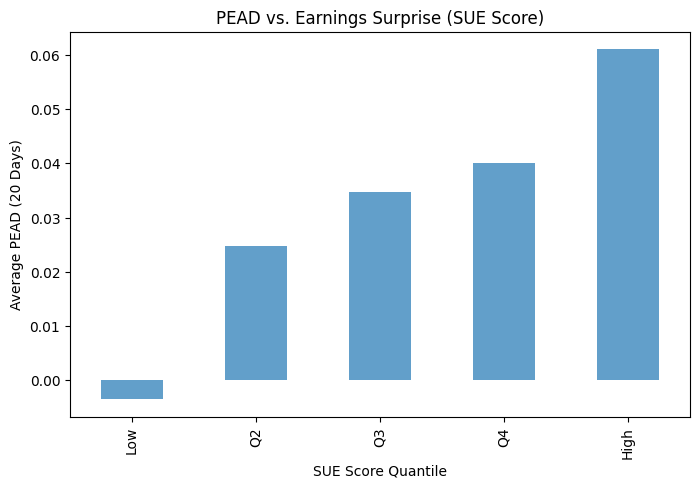

In [212]:
training_set['sue_quantile'] = pd.qcut(training_set['suescore'], q=5, labels=['Low', 'Q2', 'Q3', 'Q4', 'High'])

sue_pead_summary = training_set.groupby('sue_quantile')['pead_20d'].mean()
print(sue_pead_summary)

plt.figure(figsize=(8,5))
sue_pead_summary.plot(kind='bar',alpha=0.7)
plt.xlabel("SUE Score Quantile")
plt.ylabel("Average PEAD (20 Days)")
plt.title("PEAD vs. Earnings Surprise (SUE Score)")
plt.show()

## Strategy Implementation & Performance Analysis

In [ ]:
spy_benchmark = spy_eod_data.loc[spy_eod_data['date'].between(data_start_date, data_end_date)].copy().reset_index(drop=True)
spy_benchmark['spy_return'] = spy_benchmark['adj_close'].pct_change()
spy_benchmark['date'] = pd.to_datetime(spy_benchmark['date'])

# spy_benchmark.to_pickle('../data/spy_benchmark.pkl')
# spy_benchmark = pd.read_pickle('../data/spy_benchmark.pkl')

In [ ]:
trading_data = merged_df.loc[(merged_df['date']>=data_start_date) & (merged_df['date']<=data_end_date)].copy().reset_index(drop=True).sort_values(by=['date'])
# trading_data.to_pickle('../data/trading_data.pkl')
# trading_data = pd.read_pickle('../data/trading_data.pkl')

In [227]:
class QTS:
    def __init__(
            self, 
            data,
            benchmark_data,
            rank_features=['suescore'],
            quantile_n=5,
            holding_period=20, 
            dynamic_sizing='equal',
            stop_loss_threshold=-0.05,
            initial_funding_rate=0.043, 
            repo_spread=0.01, 
            initial_capital=1_000_000
        ):
        """
        PEAD-Based Quant Trading Strategy with Full Price Data.
        """
        self.data = data.sort_values(['date', 'ticker']).copy().reset_index(drop=True)
        self.benchmark = benchmark_data.sort_values('date').copy().reset_index(drop=True)
        self.rank_metrics = rank_features
        self.quantile_n = quantile_n
        self.holding_period = holding_period
        self.dynamic_sizing = dynamic_sizing
        self.stop_loss_threshold = stop_loss_threshold
        self.funding_rate = initial_funding_rate
        self.repo_rate = self.funding_rate - repo_spread  
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        self.pnl_data = None
        self.trade_log = []
        self.strategy_name = f"{self.holding_period}day_holding-{self.dynamic_sizing}_size-{self.quantile_n}_qtl"

    def _calculate_quantiles(self):
        """ Assign quantiles to stocks only on earnings days while keeping full price data. """

        for metric in self.rank_metrics:
            if metric not in self.data.columns:
                raise ValueError(f"Rank metric '{metric}' not found in data.")
        
        self.data['long_signal'] = False
        self.data['short_signal'] = False

        rank_df = self.data[self.rank_metrics].apply(lambda x: (x - x.mean()) / x.std(), axis=0).copy()
        self.data['rank_metric'] = rank_df.mean(axis=1)

        earnings_days = self.data[self.data['day_after_earnings'] == self.data['date']]['date'].unique()
        for date in earnings_days:
            subset = self.data[(self.data['date'] == date) & (self.data['day_after_earnings']==date)].copy()
            # Assign quantiles only for stocks reporting earnings
            subset['quantile'] = pd.qcut(subset['rank_metric'], self.quantile_n, labels=False, duplicates='drop')

            # Define Long and Short signals
            subset['long_signal'] = subset['quantile'] == subset['quantile'].max()
            # subset['short_signal'] = subset['quantile'] == subset['quantile'].min()

            # Merge updated signals into full dataset
            self.data.loc[self.data['date'] == date, ['long_signal', 'short_signal']] = subset[['long_signal', 'short_signal']]
            self.data[['long_signal', 'short_signal']] = self.data[['long_signal', 'short_signal']].fillna(False)

        self.data = self._calculate_positions(self.data)

    def _calculate_positions(self, subset_df):
        """ Assign position sizes based on quantile ranks for each earnings date separately. """

        positions_df = subset_df.copy()
        positions_df['position_size'] = 0

        # Get unique earnings announcement days
        earnings_days = positions_df['day_after_earnings'].unique()

        for date in earnings_days:
            # Select only stocks that had earnings on this date
            daily_subset = positions_df[positions_df['date'] == date].copy()

            if daily_subset.empty:
                continue

            # Apply position sizing only within stocks that reported earnings on this date
            if self.dynamic_sizing == 'equal':
                daily_subset['position_size'] = np.select(
                    [daily_subset['long_signal'], daily_subset['short_signal']],
                    [1, -1], default=0
                )

                total_symbols = daily_subset['long_signal'].sum() + daily_subset['short_signal'].sum()
                if total_symbols > 0:
                    daily_subset['position_size'] /= total_symbols  # Normalize across earnings day stocks

            elif self.dynamic_sizing == 'dynamic':
                num_long = daily_subset['long_signal'].sum()
                num_short = daily_subset['short_signal'].sum()

                if num_long > 1:
                    daily_subset.loc[daily_subset['long_signal'], 'position_size'] = daily_subset.loc[daily_subset['long_signal'], 'rank_metric'].rank(method='dense', ascending=False)

                if num_short > 1:
                    daily_subset.loc[daily_subset['short_signal'], 'position_size'] = -daily_subset.loc[daily_subset['short_signal'], 'rank_metric'].rank(method='dense', ascending=True)

                # Normalize position sizes within the earnings day
                max_pos = daily_subset['position_size'].abs().max()
                if max_pos > 0:
                    daily_subset['position_size'] /= max_pos  # Scale between -1 and 1

            # Merge updated positions back into the main dataset
            positions_df.loc[positions_df['date'] == date, 'position_size'] = daily_subset['position_size']*0.05

        return positions_df

    def _track_trades(self):
        """ Track entry and exit details for each trade, looping through daily price data to check stop-loss. """

        trading_days = sorted(self.data['date'].unique())
        trade_entries = self.data[self.data['long_signal'] | self.data['short_signal']].copy()

        # Initialize exit date as the planned holding period exit
        trade_entries['exit_date'] = trade_entries['date'].apply(
            lambda x: next((d for d in trading_days if d > x and (d - x).days >= self.holding_period), np.nan)
        )

        # Merge with exit prices
        exit_prices = self.data[['date', 'ticker', 'adj_close']].rename(columns={'date': 'exit_date', 'adj_close': 'exit_price'})
        trade_entries = trade_entries.merge(exit_prices, on=['exit_date', 'ticker'], how='left')

        trade_entries['trade_type'] = np.where(trade_entries['long_signal'], 'Long', 'Short')
        trade_entries = trade_entries.rename(columns={'date': 'entry_date', 'adj_close': 'entry_price'})
        trade_entries['notional'] = trade_entries['position_size'] * self.initial_capital

        # --- Apply Stop-Loss on a Daily Basis ---
        stop_loss_dates = []  # Store new exit dates for trades that hit stop-loss

        for index, row in trade_entries.iterrows():
            entry_date = row['entry_date']
            exit_date = row['exit_date']
            ticker = row['ticker']
            entry_price = row['entry_price']
            trade_type = row['trade_type']

            # Get price data for this ticker after entry date
            price_data = self.data[(self.data['ticker'] == ticker) & (self.data['date'] > entry_date) & (self.data['date']<=exit_date)].copy()

            for i, price_row in price_data.iterrows():
                current_date = price_row['date']
                current_price = price_row['adj_close']
                return_pct = (current_price / entry_price - 1) if trade_type == 'Long' else (entry_price / current_price - 1)

                # If stop-loss is hit, exit immediately
                if return_pct < self.stop_loss_threshold:
                    stop_loss_dates.append({'ticker': ticker, 'entry_date': entry_date, 'exit_date': current_date,'exit_price': current_price})
                    break  # Stop checking further dates once stop-loss is hit
            
            if stop_loss_dates is None:
                stop_loss_dates.append({'ticker': ticker, 'entry_date': entry_date, 'exit_date': exit_date, 'exit_price': row['exit_price']})

        # Convert stop-loss exits to DataFrame and merge with trade entries
        stop_loss_df = pd.DataFrame(stop_loss_dates)
        trade_entries = trade_entries.merge(stop_loss_df, on=['ticker','entry_date'], how='left')

        # Replace exit_date with stop-loss exit if applicable
        trade_entries['exit_date'] = trade_entries['exit_date_y'].combine_first(trade_entries['exit_date_x'])
        trade_entries['exit_price'] = trade_entries['exit_price_y'].combine_first(trade_entries['exit_price_x'])
        trade_entries.drop(columns=['exit_date_x', 'exit_date_y'], inplace=True)
        trade_entries.drop(columns=['exit_price_x', 'exit_price_y'], inplace=True)
        
        trade_entries['return'] = np.where(
            trade_entries['trade_type'] == 'Long',
            (trade_entries['exit_price'] - trade_entries['entry_price']) / trade_entries['entry_price'],
            (trade_entries['entry_price'] - trade_entries['exit_price']) / trade_entries['entry_price']
        )

        # Store updated trade log
        self.trade_log = trade_entries[['ticker', 'entry_date', 'entry_price', 'exit_date', 
                                        'exit_price', 'trade_type', 'position_size', 'notional','return']].to_dict('records')

    def _calculate_accounting(self):
        """ Compute detailed PnL metrics using trade logs, including repo costs and cumulative returns. """
    
        trade_df = pd.DataFrame(self.trade_log)

        if trade_df.empty:
            print("Error: No trades recorded. Check signal generation.")
            return

        # Compute trade returns and PnL
        trade_df['trade_return'] = np.where(
            trade_df['trade_type'] == 'Long',
            (trade_df['exit_price'] - trade_df['entry_price']) / trade_df['entry_price'],
            (trade_df['entry_price'] - trade_df['exit_price']) / trade_df['entry_price']
        )

        # Compute PnL per trade
        trade_df['pnl'] = trade_df['trade_return'] * abs(trade_df['notional'])

        # Calculate repo cost (for short positions)
        trade_df['repo_cost'] = -self.repo_rate / 252 * trade_df['position_size'].clip(upper=0) * trade_df['entry_price']

        # Compute net PnL (including repo cost)
        trade_df['net_pnl'] = trade_df['pnl'] + trade_df['repo_cost']

        # Compute net return based on initial capital
        trade_df['net_ret'] = trade_df['net_pnl'] / self.initial_capital

        # Aggregate cumulative PnL over time
        self.pnl_data = trade_df.groupby('exit_date')[['pnl', 'repo_cost', 'net_pnl', 'net_ret']].sum().reset_index()
        self.pnl_data['cumulative_pnl'] = self.pnl_data['net_pnl'].cumsum()
        self.pnl_data['cumulative_ret'] = self.pnl_data['net_ret'].cumsum()
        self.pnl_data.rename(columns={'exit_date':'date'}, inplace=True)

    def backtest(self):
        """ Run backtest while preserving full price data. """
        print(f"Starting Backtest for {self.strategy_name}...")
        self._calculate_quantiles()
        self._track_trades()
        self._calculate_accounting()
        self.performance_metrics()

    def get_trade_log(self):
        """ Display trade history. """
        trade_df = pd.DataFrame(self.trade_log)
        return trade_df

    def plot_pnl(self):
        """ Plot cumulative PnL over time. """
        plt.figure(figsize=(12, 4))
        plt.plot(self.pnl_data['date'], self.pnl_data['cumulative_pnl'], label='Cumulative Net PnL')
        plt.title(f"Strategy Cumulative Daily PnL Over Time")
        plt.xlabel("Date")
        plt.ylabel("PnL ($)")
        plt.legend()
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
        plt.grid(axis='y', linestyle='-', alpha=0.7)  
        plt.grid(axis='x', linestyle='-', alpha=0.7)  
        plt.show()

    def performance_metrics(self, annualization_factor=252):
        """ Compute strategy performance metrics. """
        daily_returns = self.pnl_data.groupby('date')['net_ret'].sum().reset_index()['net_ret']
        merged_df = self.pnl_data.merge(self.benchmark[['date', 'adj_close']], on='date', how='left', suffixes=('', '_benchmark'))
        merged_df['benchmark_ret'] = merged_df['adj_close'].pct_change()
        merged_df['excess_ret'] = merged_df['net_ret'] - merged_df['benchmark_ret']

        self.perf_metrics =  pd.DataFrame({'Mean': [daily_returns.mean() * annualization_factor]})
        self.perf_metrics['Volatility'] = daily_returns.std() * np.sqrt(annualization_factor)
        self.perf_metrics['Sharpe Ratio'] = (daily_returns.mean()) / daily_returns.std() * np.sqrt(annualization_factor)
        
        mean_excess_ret = merged_df['excess_ret'].mean() * annualization_factor
        std_excess_ret = merged_df['excess_ret'].std() * np.sqrt(annualization_factor)
        information_ratio = mean_excess_ret / std_excess_ret if std_excess_ret != 0 else np.nan
        self.perf_metrics['Information Ratio'] = information_ratio

        X = sm.add_constant(merged_df['benchmark_ret']) 
        Y = merged_df['net_ret']
        
        model = sm.OLS(Y, X, missing='drop').fit() 
        beta = model.params[1] 
        alpha = model.params[0] * annualization_factor 

        self.perf_metrics['Beta'] = beta
        self.perf_metrics['Alpha'] = alpha
        self.perf_metrics['Skewness'] = daily_returns.skew()
        self.perf_metrics['Kurtosis'] = daily_returns.kurtosis()
        self.perf_metrics['Var (0.05)'] = daily_returns.quantile(0.05)
        self.perf_metrics['CVaR (0.05)'] = daily_returns[daily_returns <= daily_returns.quantile(0.05)].mean()

        wealth_index = 1000 * (1 + daily_returns).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks) / previous_peaks
        self.perf_metrics['Max Drawdown'] = drawdowns.min()
        
        self.perf_metrics.rename(index={0: self.strategy_name}, inplace=True)
        self.perf_metrics = self.perf_metrics.round(4)

Starting Backtest for 5day_holding-equal_size-5_qtl...


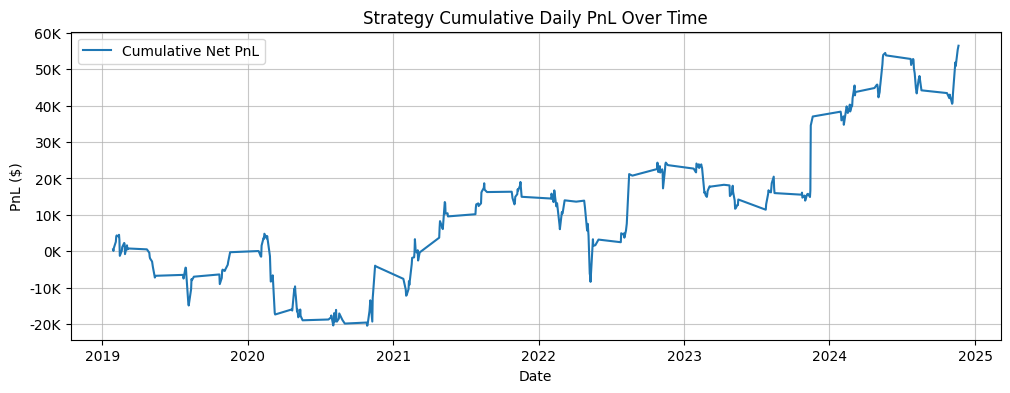

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
5day_holding-equal_size-5_qtl,0.0423,0.0404,1.0465,-1.9905,0.0329,0.0174,1.0027,9.9584,-0.0033,-0.0055,-0.0272


Starting Backtest for 5day_holding-equal_size-8_qtl...


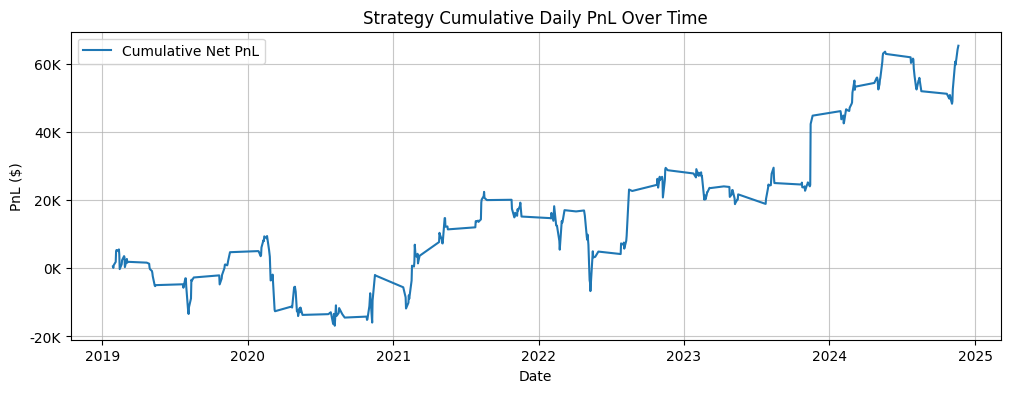

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
5day_holding-equal_size-8_qtl,0.0502,0.043,1.1666,-1.9952,0.0338,0.024,0.8479,8.044,-0.0034,-0.0058,-0.0289


Starting Backtest for 5day_holding-equal_size-10_qtl...


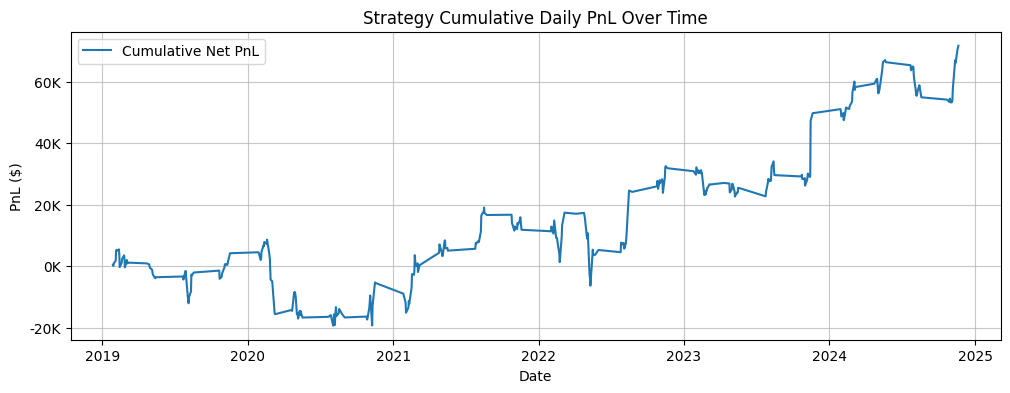

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
5day_holding-equal_size-10_qtl,0.0554,0.0438,1.2638,-2.0268,0.0329,0.0299,0.6371,8.0904,-0.0034,-0.0059,-0.0277


Starting Backtest for 5day_holding-equal_size-15_qtl...


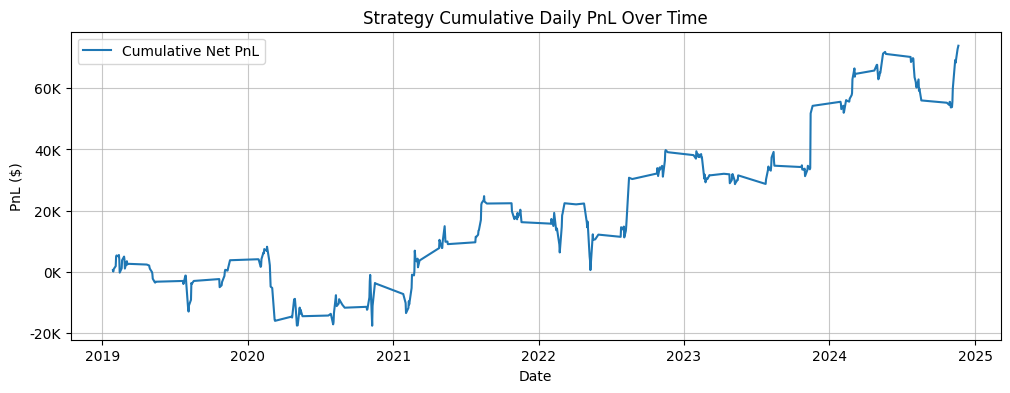

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
5day_holding-equal_size-15_qtl,0.058,0.0468,1.2397,-2.0279,0.0354,0.0301,0.1483,8.5915,-0.0034,-0.0062,-0.0258


Starting Backtest for 20day_holding-equal_size-5_qtl...


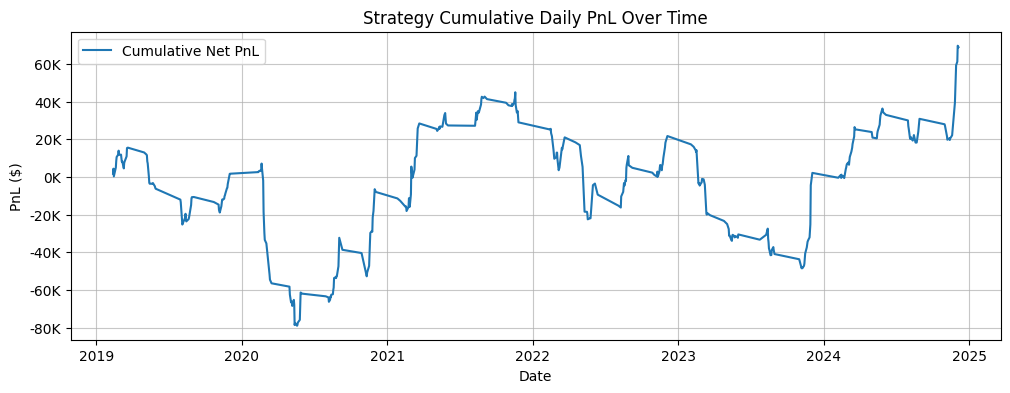

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
20day_holding-equal_size-5_qtl,0.0438,0.0629,0.6952,-1.5982,0.0193,0.0304,0.0703,5.355,-0.0056,-0.0094,-0.0908


Starting Backtest for 20day_holding-equal_size-8_qtl...


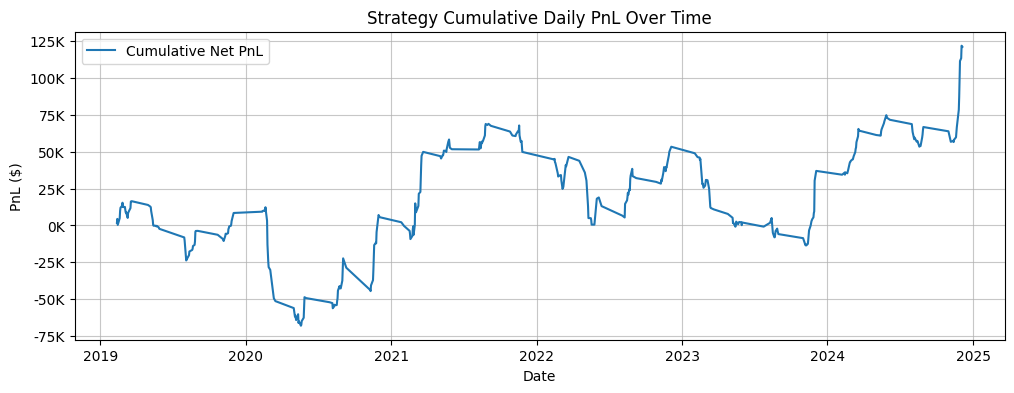

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
20day_holding-equal_size-8_qtl,0.0826,0.0718,1.151,-1.6159,0.0184,0.0691,0.6017,5.5786,-0.0059,-0.0097,-0.0814


Starting Backtest for 20day_holding-equal_size-10_qtl...


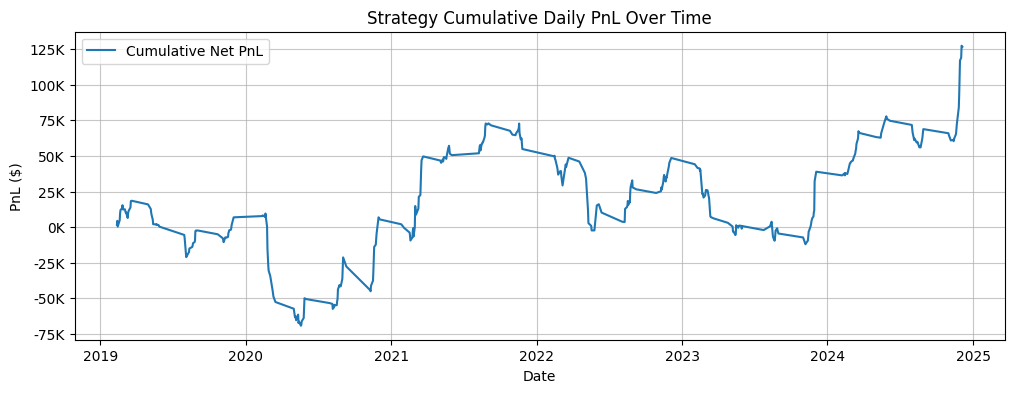

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
20day_holding-equal_size-10_qtl,0.0887,0.0741,1.197,-1.6232,0.021,0.073,0.4478,5.3387,-0.0059,-0.0102,-0.0846


Starting Backtest for 20day_holding-equal_size-15_qtl...


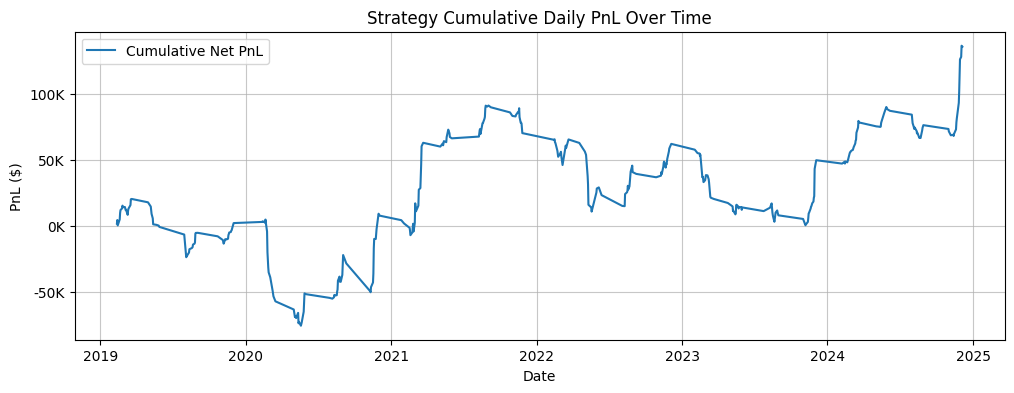

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
20day_holding-equal_size-15_qtl,0.0986,0.0799,1.2338,-1.623,0.0205,0.0827,0.3593,4.9986,-0.0063,-0.011,-0.0925


Starting Backtest for 60day_holding-equal_size-5_qtl...


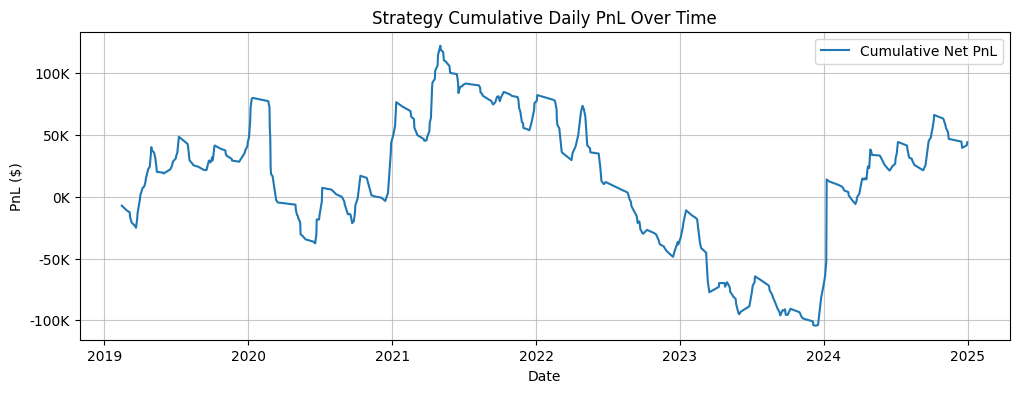

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
60day_holding-equal_size-5_qtl,0.0282,0.1053,0.2678,-1.5681,0.0365,0.0103,3.0532,26.9843,-0.0071,-0.0118,-0.2043


Starting Backtest for 60day_holding-equal_size-8_qtl...


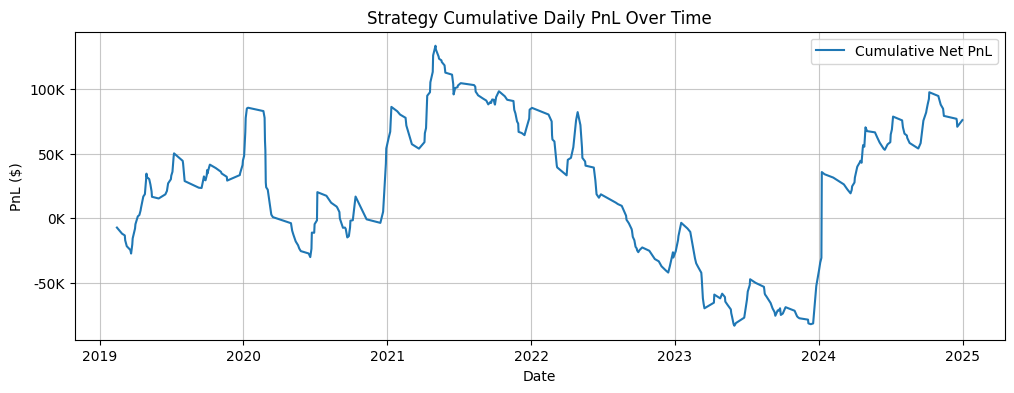

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
60day_holding-equal_size-8_qtl,0.0546,0.1177,0.4641,-1.6716,0.0394,0.0328,2.7575,20.3048,-0.0072,-0.0124,-0.196


Starting Backtest for 60day_holding-equal_size-10_qtl...


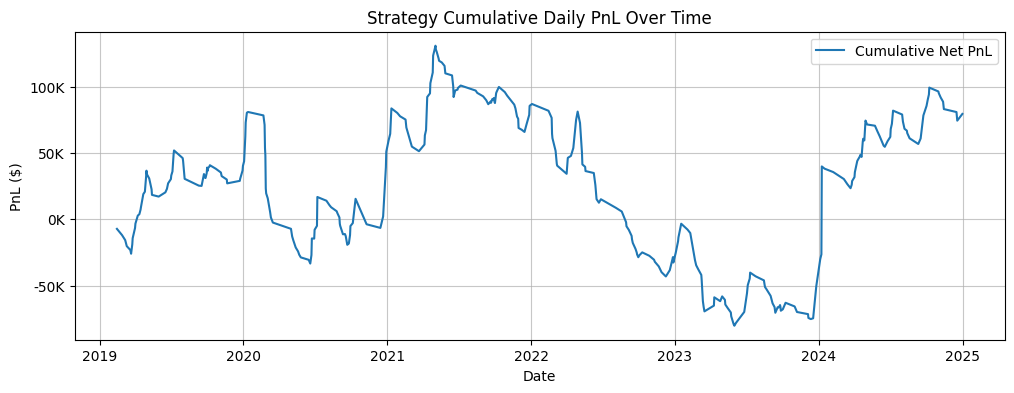

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
60day_holding-equal_size-10_qtl,0.0598,0.1208,0.4951,-1.6784,0.0361,0.0393,2.5726,18.7697,-0.0074,-0.0132,-0.1919


Starting Backtest for 60day_holding-equal_size-15_qtl...


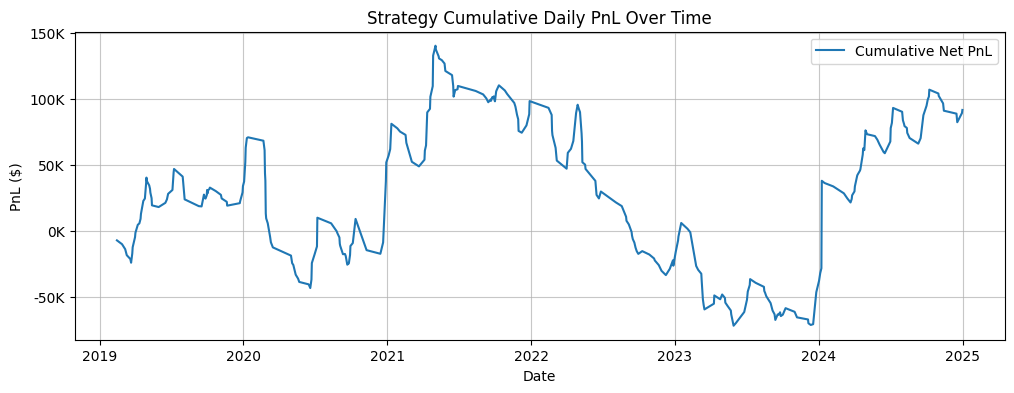

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
60day_holding-equal_size-15_qtl,0.073,0.1294,0.5646,-1.7138,0.035,0.0522,2.4583,16.7522,-0.0084,-0.0143,-0.1928


Starting Backtest for 90day_holding-equal_size-5_qtl...


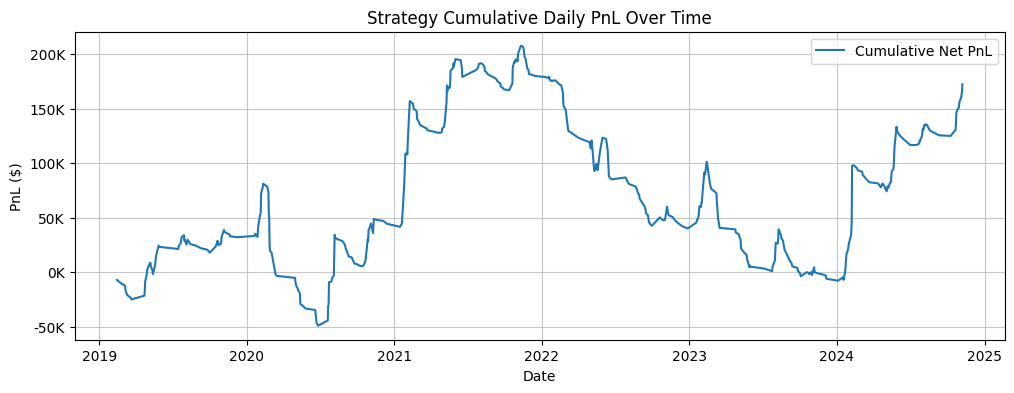

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
90day_holding-equal_size-5_qtl,0.1015,0.1015,1.0003,-1.316,0.043,0.081,1.7576,12.1959,-0.0069,-0.0117,-0.1958


Starting Backtest for 90day_holding-equal_size-8_qtl...


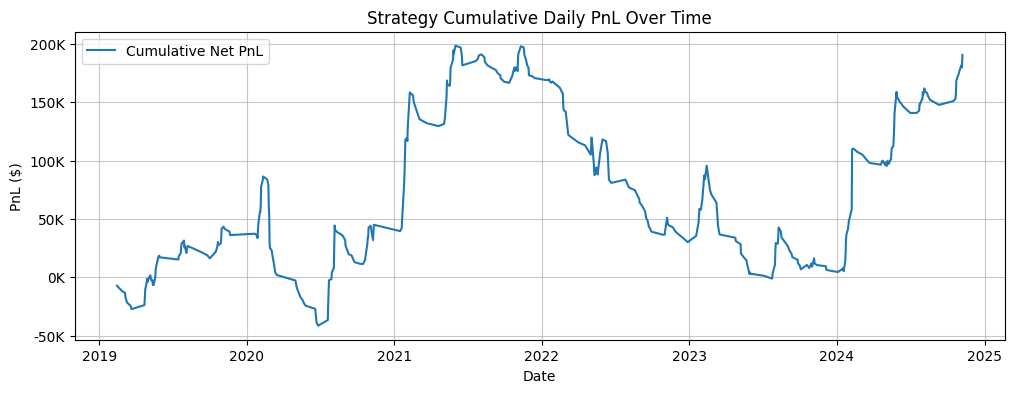

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
90day_holding-equal_size-8_qtl,0.1288,0.1137,1.1327,-1.3891,0.0418,0.1062,1.7199,9.649,-0.0072,-0.0125,-0.183


Starting Backtest for 90day_holding-equal_size-10_qtl...


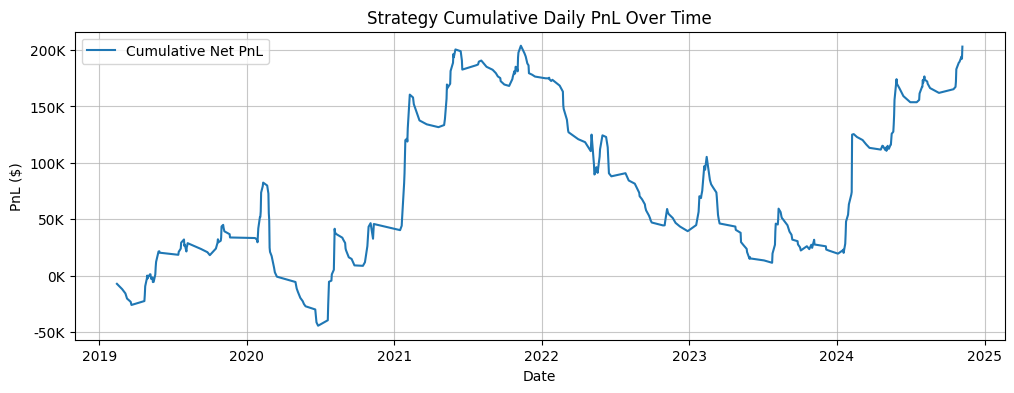

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
90day_holding-equal_size-10_qtl,0.1445,0.1181,1.2236,-1.3802,0.0373,0.1238,1.5712,8.5138,-0.008,-0.0132,-0.1769


Starting Backtest for 90day_holding-equal_size-15_qtl...


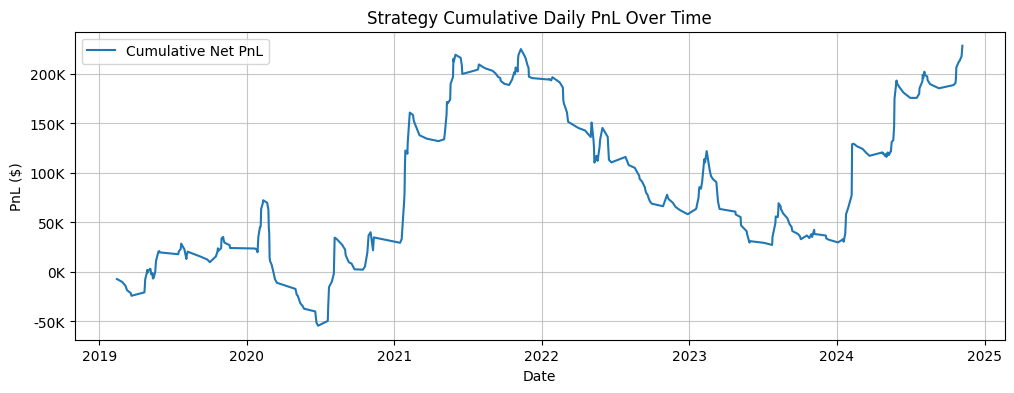

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
90day_holding-equal_size-15_qtl,0.1734,0.1278,1.3565,-1.365,0.0346,0.1534,1.4866,6.7547,-0.0085,-0.0141,-0.1815


Starting Backtest for 120day_holding-equal_size-5_qtl...


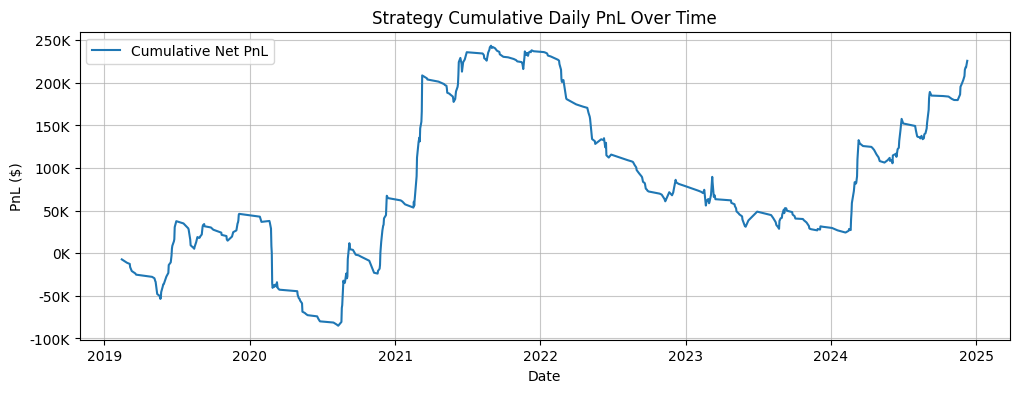

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
120day_holding-equal_size-5_qtl,0.1343,0.1069,1.2555,-1.2051,0.0174,0.1284,1.0501,6.9919,-0.0067,-0.0121,-0.1985


Starting Backtest for 120day_holding-equal_size-8_qtl...


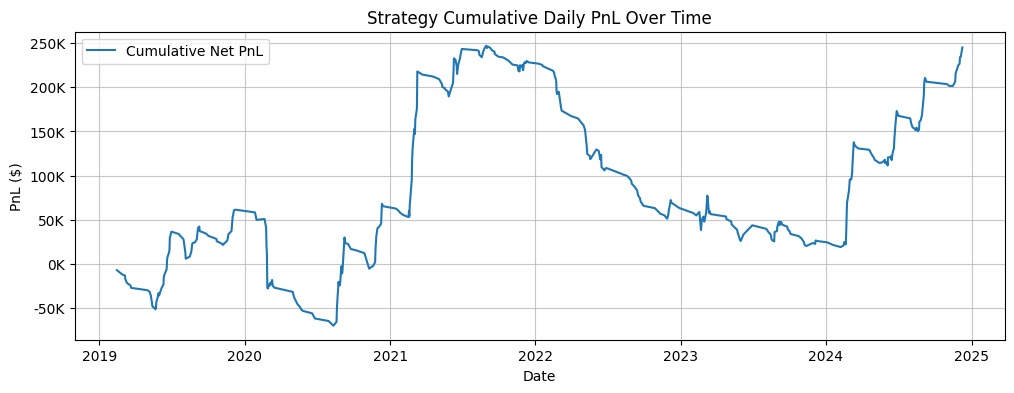

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
120day_holding-equal_size-8_qtl,0.1648,0.1206,1.3661,-1.269,0.0179,0.1581,1.06,6.0849,-0.0072,-0.0132,-0.2056


Starting Backtest for 120day_holding-equal_size-10_qtl...


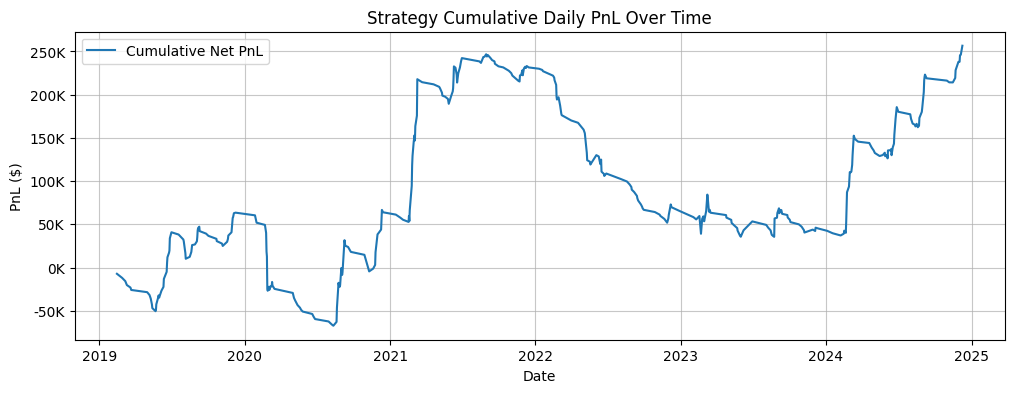

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
120day_holding-equal_size-10_qtl,0.1827,0.1263,1.4467,-1.2774,0.0147,0.1779,0.9644,5.2274,-0.0076,-0.0141,-0.192


Starting Backtest for 120day_holding-equal_size-15_qtl...


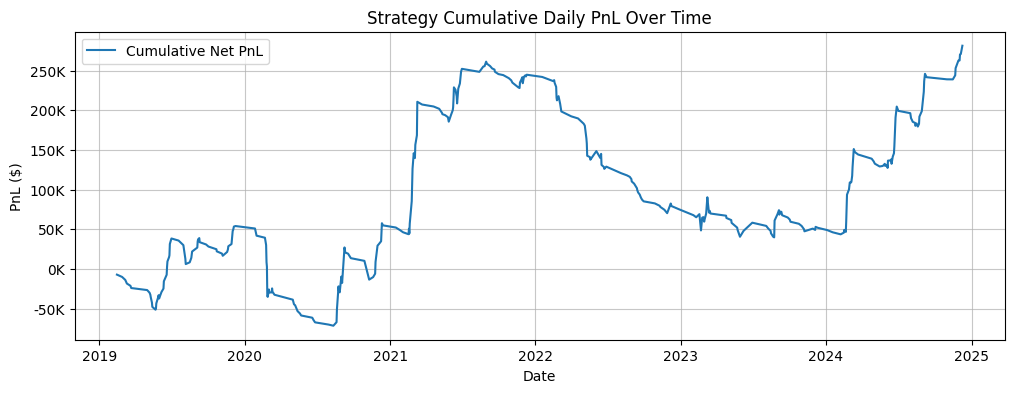

,Mean,Volatility,Sharpe Ratio,Information Ratio,Beta,Alpha,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
120day_holding-equal_size-15_qtl,0.2156,0.1365,1.5792,-1.278,0.0171,0.2086,0.9865,4.4828,-0.0085,-0.0151,-0.2004


In [264]:
test_date = '2024-12-31'

holding_periods = [5, 20, 60, 90, 120]
quantiles = [5, 8, 10, 15]

bts_list = {}

for n in holding_periods:
    for q in quantiles:
        key = f"{n}D_{q}Q"
        strategy_backtest = QTS(
            data=trading_data.loc[trading_data.date<=test_date].sort_values(by=['date']).reset_index(drop=True), 
            benchmark_data=spy_benchmark.loc[spy_benchmark.date<=test_date].sort_values(by=['date']).reset_index(drop=True),
            rank_features=['mom_126', 'mom_252', 'log_mkt_cap', 'cgo', 'fcf_yield', 'ebitda_margin', 'pead_20d', 'mom_21', 'roi_scaled', 'suescore'],
            quantile_n=q,  
            holding_period=n, 
            dynamic_sizing='equal',
            stop_loss_threshold=-0.05,
        )
        strategy_backtest.backtest()
        bts_list[key] = strategy_backtest
        strategy_backtest.plot_pnl()
        display(strategy_backtest.perf_metrics)

In [242]:
trade_log_df = bts_list[20].get_trade_log().dropna()
display(trade_log_df.head())
display(trade_log_df.tail())

,ticker,entry_date,entry_price,exit_date,exit_price,trade_type,position_size,notional,return
0,IBM,2019-01-23,95.875301,2019-02-12,99.312147,Long,0.050,50000.0,0.035847
1,PG,2019-01-24,81.695940,2019-02-13,85.975664,Long,0.050,50000.0,0.052386
2,SBUX,2019-01-25,59.472197,2019-02-14,63.124747,Long,0.050,50000.0,0.061416
3,CE,2019-01-29,84.370183,2019-02-19,88.957443,Long,0.050,50000.0,0.054371
4,MKSI,2019-01-30,77.689189,2019-02-19,81.020089,Long,0.025,25000.0,0.042875


,ticker,entry_date,entry_price,exit_date,exit_price,trade_type,position_size,notional,return
752,AAOI,2024-11-08,27.760000,2024-11-29,41.22,Long,0.025,25000.0,0.484870
753,WWW,2024-11-08,21.970000,2024-11-29,23.19,Long,0.025,25000.0,0.055530
754,HE,2024-11-11,9.970000,2024-12-02,10.35,Long,0.050,50000.0,0.038114
755,ENR,2024-11-13,33.110379,2024-12-03,38.72,Long,0.050,50000.0,0.169422
756,IP,2024-11-15,57.580000,2024-12-05,56.71,Long,0.050,50000.0,-0.015109


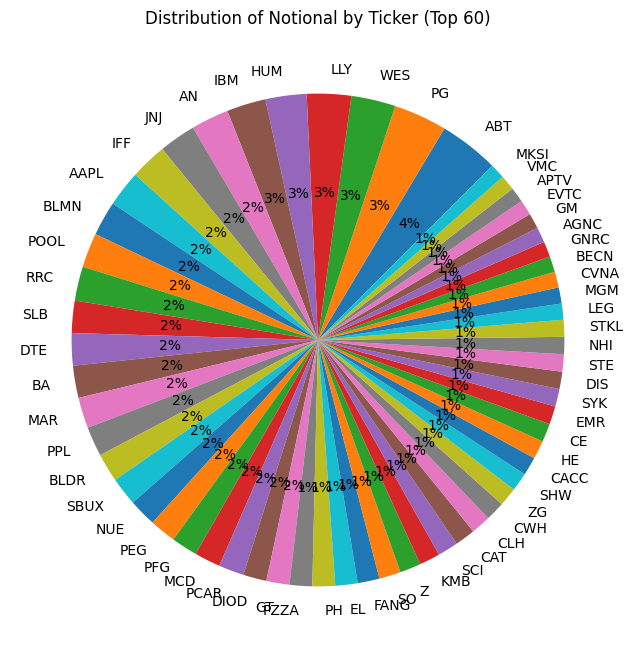

In [243]:
plot_df = trade_log_df.copy()
total_notional = plot_df['notional'].sum()
plot_df = (plot_df.groupby(['ticker'])['notional'].sum()/total_notional).reset_index().sort_values('notional', ascending=False).head(60)
plt.figure(figsize=(10, 8))
plt.pie(
    plot_df['notional'], 
    labels=plot_df['ticker'], 
    autopct='%1.0f%%',
    startangle=45,    
    textprops={'fontsize': 10}
)

plt.title("Distribution of Notional by Ticker (Top 60)")

plt.show()

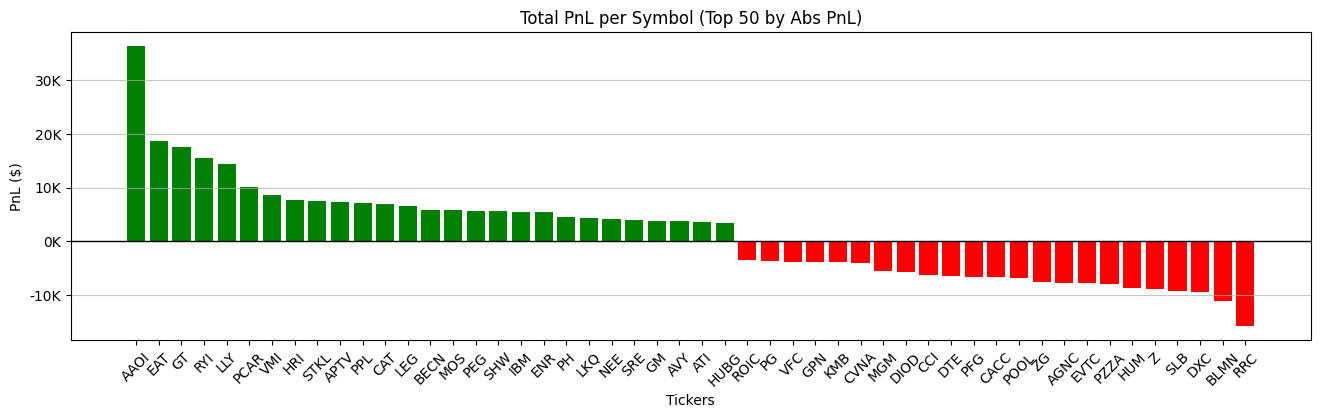

In [263]:
trade_log_df['pnl'] = trade_log_df['notional'] * trade_log_df['return']
plot_df = trade_log_df.copy()
plot_df = plot_df.groupby(['ticker'])['pnl'].sum().reset_index().sort_values('pnl', ascending=False).reset_index(drop=True)
plot_df = plot_df.loc[plot_df['pnl'].abs().nlargest(50).index].sort_values(by='pnl', ascending=False)

colors = plot_df['pnl'].apply(lambda x: 'green' if x > 0 else 'red')

plt.figure(figsize=(16, 4))
plt.bar(plot_df['ticker'], plot_df['pnl'], color=colors)

plt.xlabel('Tickers')
plt.ylabel('PnL ($)')
plt.title('Total PnL per Symbol (Top 50 by Abs PnL)')
plt.xticks(rotation=45)

plt.axhline(0, color='black', linewidth=1)

plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()

In [240]:
pnl_df = bts_list[20].pnl_data.copy()

display(pnl_df.head())
display(pnl_df.tail())

,date,pnl,repo_cost,net_pnl,net_ret,cumulative_pnl,cumulative_ret
0,2019-02-12,1792.351848,0.0,1792.351848,0.001792,1792.351848,0.001792
1,2019-02-13,2619.300106,0.0,2619.300106,0.002619,4411.651954,0.004412
2,2019-02-14,-4085.629598,0.0,-4085.629598,-0.004086,326.022356,0.000326
3,2019-02-19,4726.905611,0.0,4726.905611,0.004727,5052.927966,0.005053
4,2019-02-20,3402.911727,0.0,3402.911727,0.003403,8455.839693,0.008456


,date,pnl,repo_cost,net_pnl,net_ret,cumulative_pnl,cumulative_ret
392,2024-11-27,6321.038470,0.0,6321.038470,0.006321,45792.923340,0.045793
393,2024-11-29,13510.014639,0.0,13510.014639,0.013510,59302.937978,0.059303
394,2024-12-02,1905.717151,0.0,1905.717151,0.001906,61208.655130,0.061209
395,2024-12-03,8471.092149,0.0,8471.092149,0.008471,69679.747279,0.069680
396,2024-12-05,-755.470650,0.0,-755.470650,-0.000755,68924.276629,0.068924


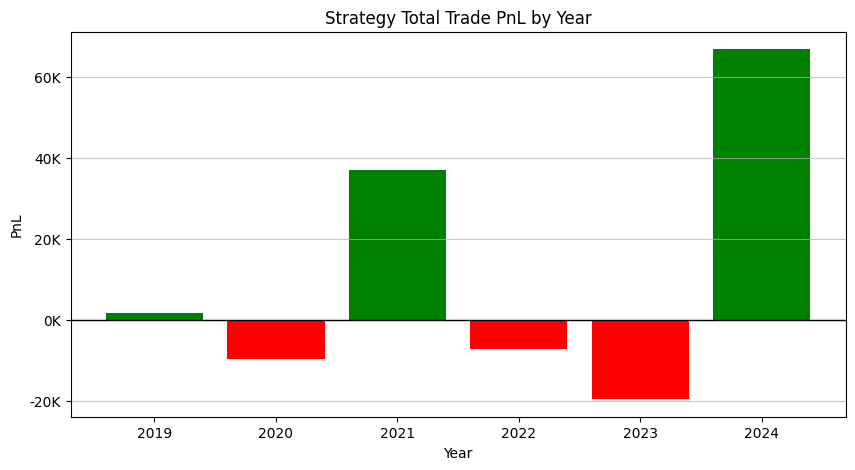

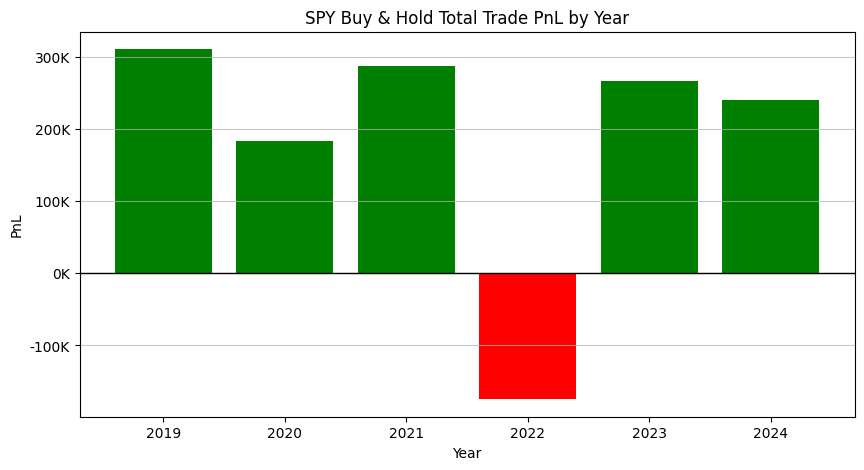

In [241]:
df = pnl_df.copy()
df['year'] = pd.to_datetime(df.date).dt.year

pnl_by_year = df.groupby('year')['pnl'].sum()

colors = ['green' if pnl >= 0 else 'red' for pnl in pnl_by_year]

plt.figure(figsize=(10, 5))
plt.bar(pnl_by_year.index, pnl_by_year, color=colors)
plt.xlabel("Year")
plt.ylabel("PnL")
plt.title("Strategy Total Trade PnL by Year")
plt.axhline(0, color='black', linewidth=1)  
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()

df = spy_benchmark.copy() 
df['year'] = pd.to_datetime(df.date).dt.year 
initial_capital = 1_000_000 

df['cumulative_return'] = (1 + df['spy_return']).groupby(df['year']).cumprod()

df['pnl'] = initial_capital * df['cumulative_return']

pnl_by_year = df.groupby('year').last()['pnl'] - initial_capital

colors = ['green' if pnl >= 0 else 'red' for pnl in pnl_by_year]

plt.figure(figsize=(10, 5))
plt.bar(pnl_by_year.index, pnl_by_year, color=colors)
plt.xlabel("Year")
plt.ylabel("PnL")
plt.title("SPY Buy & Hold Total Trade PnL by Year")
plt.axhline(0, color='black', linewidth=1)  # Add a baseline at 0
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()

In [239]:
annualization_factor = 252

daily_returns = spy_benchmark.groupby('date')['spy_return'].sum().reset_index()['spy_return']

perf_metrics =  pd.DataFrame({'Mean': [daily_returns.mean() * annualization_factor]})
perf_metrics['Volatility'] = daily_returns.std() * np.sqrt(annualization_factor)
perf_metrics['Sharpe Ratio'] = (daily_returns.mean()) / daily_returns.std() * np.sqrt(annualization_factor)

perf_metrics['Skewness'] = daily_returns.skew()
perf_metrics['Kurtosis'] = daily_returns.kurtosis()
perf_metrics['Var (0.05)'] = daily_returns.quantile(0.05)
perf_metrics['CVaR (0.05)'] = daily_returns[daily_returns <= daily_returns.quantile(0.05)].mean()

wealth_index = 1000 * (1 + daily_returns).cumprod()
previous_peaks = wealth_index.cummax()
drawdowns = (wealth_index - previous_peaks) / previous_peaks
perf_metrics['Max Drawdown'] = drawdowns.min()

perf_metrics.rename(index={0: 'SPY'}, inplace=True)
perf_metrics = perf_metrics.round(4)
perf_metrics

,Mean,Volatility,Sharpe Ratio,Skewness,Kurtosis,Var (0.05),CVaR (0.05),Max Drawdown
SPY,0.1787,0.1982,0.9018,-0.5752,12.3791,-0.0179,-0.0302,-0.337


## References

Frazzini, A. (2006). The disposition effect and underreaction to news. Journal of Finance, 61(4), 2017–2046. https://doi.org/10.1111/j.1540-6261.2006.00896

Hong, H., Lim, T., & Stein, J. C. (2000). Bad news travels slowly: Size, analyst coverage, and the profitability of momentum strategies. The Journal of Finance, 55(1), 265–295. https://doi.org/10.1111/0022-1082.00206

Ye, Z. J., & Schuller, B. W. (2021). Capturing dynamics of post-earnings-announcement drift using a genetic algorithm-optimized XGBoost. Expert Systems with Applications, 168, 114892. https://doi.org/10.1016/j.eswa.2021.114892
